## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawim' #dataset-compression
TRANSFORM = 'cwt-statement_1' #transform-group
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
statement_1_cwt_1e5rawim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawim\\cwt\\statement_1'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))
NUM_BANDS = int(10) #Change to len(group_data_map) to use all bands

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
    print(group_data_map)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


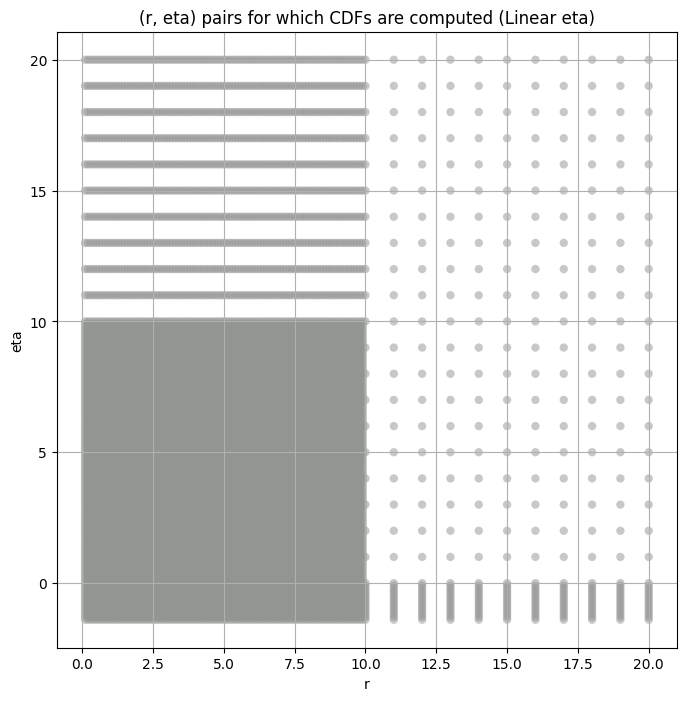

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     9.336108e+08  8.401879e+08  1.032820e+09   13.948858   11.880588   
5     2.283666e+09  2.135150e+09  2.436663e+09    4.631856    4.062694   
8     1.704543e+09  1.595908e+09  1.816450e+09    4.383642    3.860077   
11    1.321304e+09  1.240478e+09  1.403715e+09    3.787782    3.411390   
14    3.543411e+08  3.241691e+08  3.857620e+08    9.472601    8.316524   
18    6.934319e+07  6.348580e+07  7.567561e+07    9.638128    7.366555   
21    2.952826e+07  2.662045e+07  3.271980e+07   13.813057   10.137962   
24    1.138538e+07  9.675729e+06  1.334888e+07   37.156307   26.229534   
27    4.082310e+06  3.265270e+06  5.048213e+06   69.656845   46.320540   
31    1.409234e+05  1.055836e+05  1.967107e+05  147.243120   60.025883   

      kurt_upper  total_samples  
band                             
2      16.470263       100000.0  
5       5.248331       100000.0  
8       4.927763       100000.0  
11      4.184121       100000.0  
14     10.697055       100000.0  
18     12.757142       100000.0  
21     19.820702       100000.0  
24     51.107258       100000.0  
27     98.562770       100000.0  
31    424.687560       100000.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     9.336108e+08   9.336108e+08    9.020895e+08    8.784070e+08   
5     2.283666e+09   2.283666e+09    2.247455e+09    2.217635e+09   
8     1.704543e+09   1.704543e+09    1.679683e+09    1.657929e+09   
11    1.321304e+09   1.321304e+09    1.306352e+09    1.292920e+09   
14    3.543411e+08   3.543411e+08    3.458335e+08    3.387286e+08   
18    6.934319e+07   6.934319e+07    6.693323e+07    6.529311e+07   
21    2.952826e+07   2.952826e+07    2.822073e+07    2.736811e+07   
24    1.138538e+07   1.138538e+07    1.044960e+07    9.845965e+06   
27    4.082310e+06   4.082310e+06    3.575558e+06    3.268644e+06   
31    1.409234e+05   1.409234e+05    1.155773e+05    1.033528e+05   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       8.576861e+08     8.389334e+08     8.056081e+08     7.762820e+08   
5       2.190709e+09     2.165745e+09     2.120087e+09     2.078541e+09   
8       1.638000e+09     1.619459e+09     1.585464e+09     1.554553e+09   
11      1.280318e+09     1.268350e+09     1.245895e+09     1.224969e+09   
14      3.323575e+08     3.264995e+08     3.158997e+08     3.064008e+08   
18      6.392700e+07     6.272945e+07     6.066539e+07     5.890021e+07   
21      2.666740e+07     2.606006e+07     2.502968e+07     2.416484e+07   
24      9.368484e+06     8.968661e+06     8.318590e+06     7.799567e+06   
27      3.036272e+06     2.848079e+06     2.553947e+06     2.328954e+06   
31      9.450646e+04     8.760196e+04     7.723941e+04     6.961947e+04   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        7.498707e+08     7.257204e+08     7.033584e+08     6.444129e+08  
5        2.040041e+09     2.004007e+09     1.970036e+09     1.877838e+09  
8        1.526023e+09     1.499406e+09     1.474384e+09     1.406661e+09  
11       1.205241e+09     1.186494e+09     1.168587e+09     1.118928e+09  
14       2.977308e+08     2.897235e+08     2.822593e+08     2.624262e+08  
18       5.734344e+07     5.594378e+07     5.466763e+07     5.138646e+07  
21       2.341506e+07     2.275017e+07     2.215101e+07     2.062339e+07  
24       7.367641e+06     6.998612e+06     6.677269e+06     5.909514e+06  
27       2.148212e+06     1.998265e+06     1.870978e+06     1.579554e+06  
31       6.367023e+04     5.884447e+04     5.481603e+04     4.576621e+04

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.02148120900588376 933610800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.022376393208458634 902089500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.023066588447218095 878407000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.023688411495811967 857686100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.02426334928878332 838933440.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.02378925128809628 805608060.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.02421045979650127 776282050.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.02510941942636835 749870700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.025961367843790065 725720450.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.026751150052453876 703358400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.02728643470828867 644412860.0
Number of samples: 100000, Without approximation : 100000.0


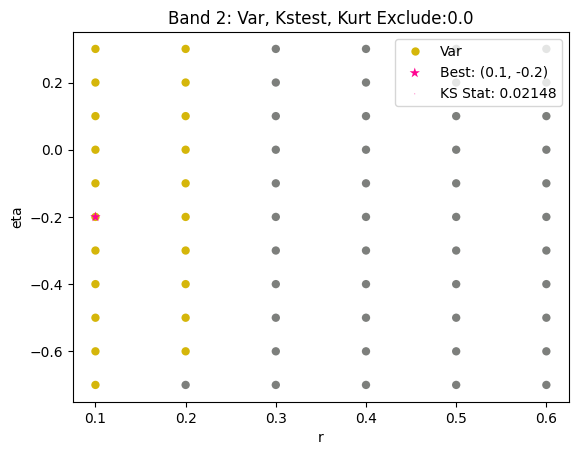

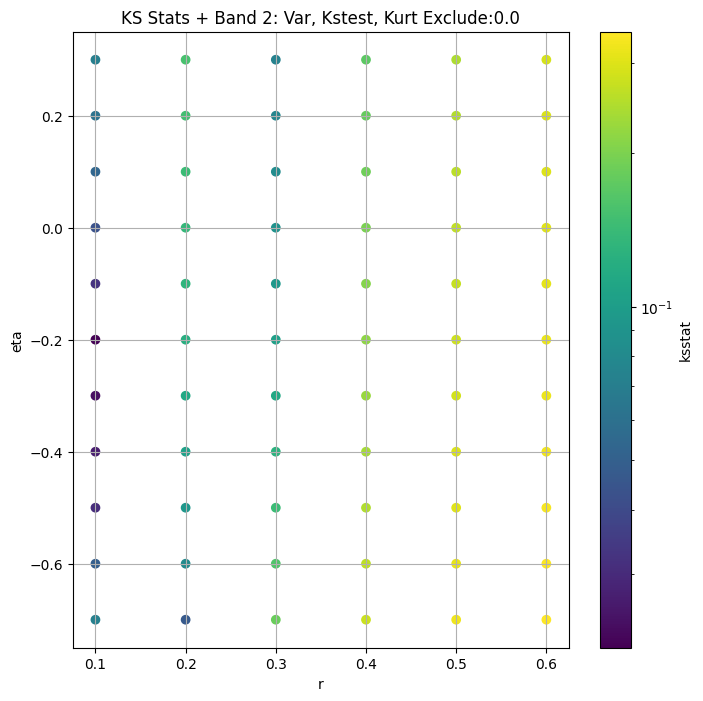

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.034753017899373906 2283666200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.03443574082172329 2247455000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.03521190321557477 2217634800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.035919463574365706 2190709000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.036581279594876004 2165745200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.03781469241692499 2120087200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.03791195125049629 2078541300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.037303487694278714 2040041500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.03724845199893034 2004007000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.03824248769020196 1970035800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.04006196177619836 1877838100.0
Number of samples: 100000, Without approximation : 100000.0


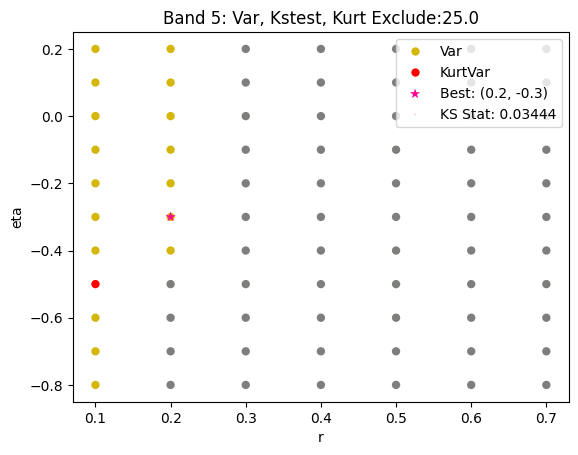

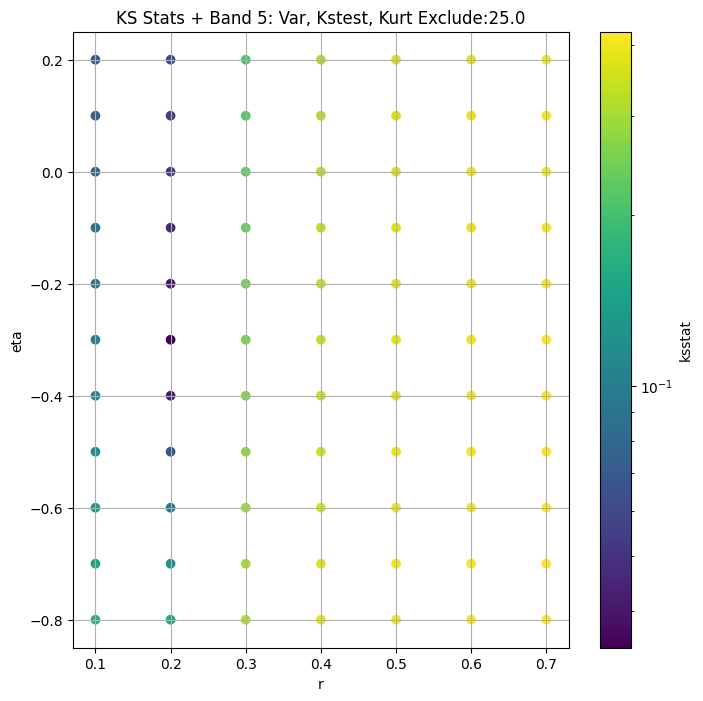

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.023658907677168883 1704543400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.02411083391162927 1679683300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.023755888823196902 1657929000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.02343036388378933 1637999600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.02404985950116445 1619459100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.02549089140506211 1585463600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.02496863177298314 1554552600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.025412530437046527 1526023200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.02660348431439387 1499406300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.02623480496784314 1474384000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.02743430784577172 1406660900.0
Number of samples: 100000, Without approximation : 100000.0


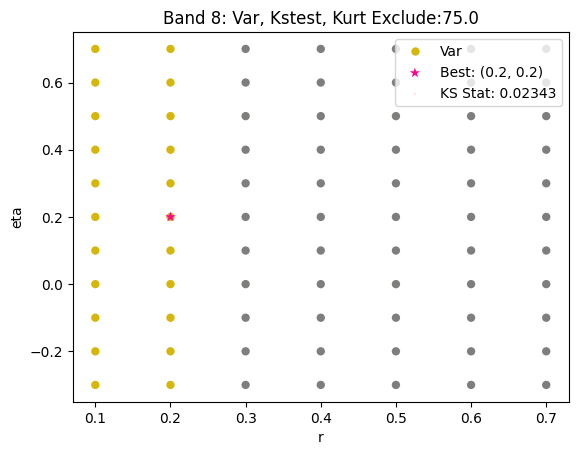

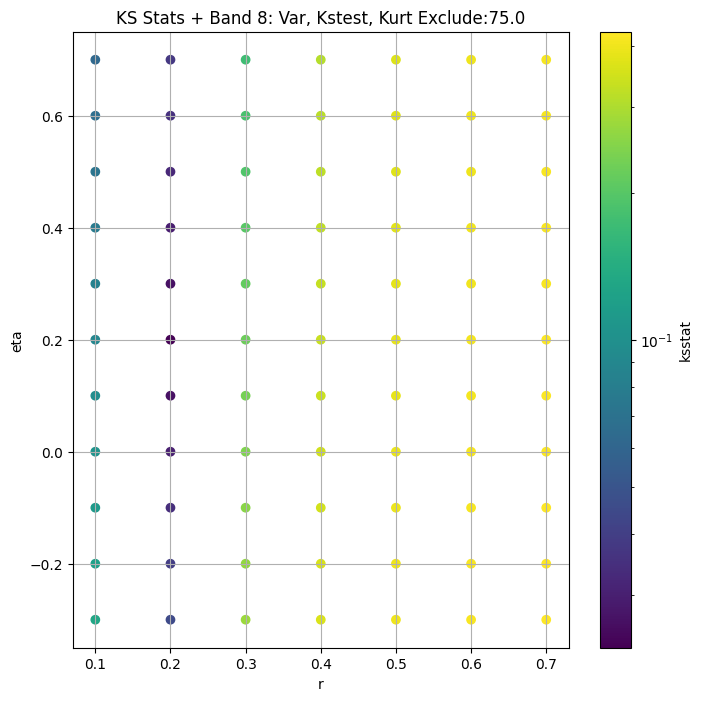

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.026291044847811737 1321303700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.02693016957918333 1306351600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.02751141034814386 1292920000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.028062017671765915 1280318100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.02859256465710737 1268350300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.028739052902969298 1245895300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.028118409892620044 1224969100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.028918329141687682 1205241100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.029801165554933312 1186493800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.030655311626840293 1168586600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.030915464134327317 1118927700.0
Number of samples: 100000, Without approximation : 100000.0


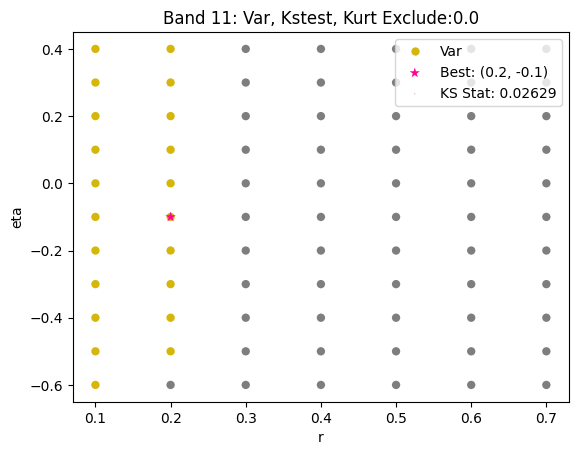

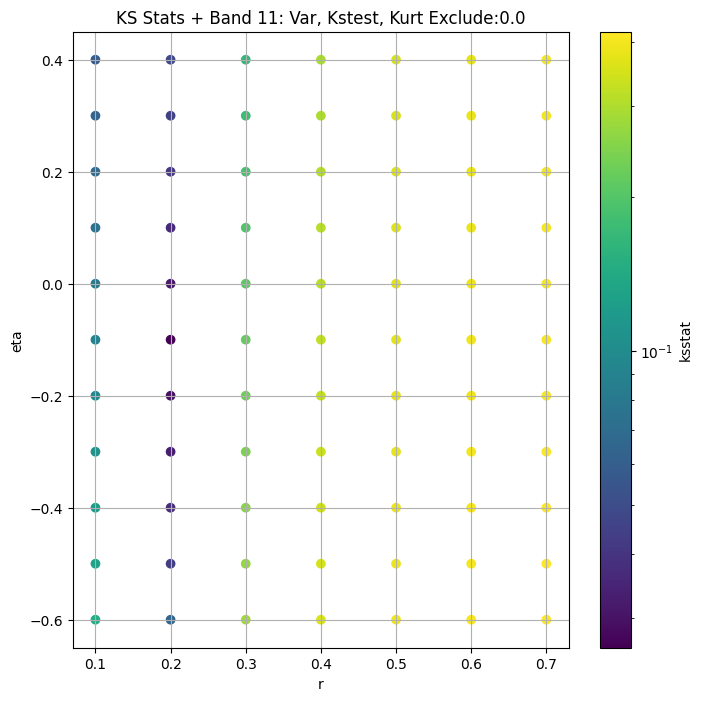

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.02032640119942722 354341100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.021619555480184016 345833470.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.021955178209401738 338728640.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.02129073588503605 332357500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.020685400842898716 326499500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.02077073257059525 315899680.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.022379828835685928 306400830.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.023898685418403648 297730850.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.025313617650625342 289723460.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.02438672412121079 282259260.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.02607112379247102 262426220.0
Number of samples: 100000, Without approximation : 100000.0


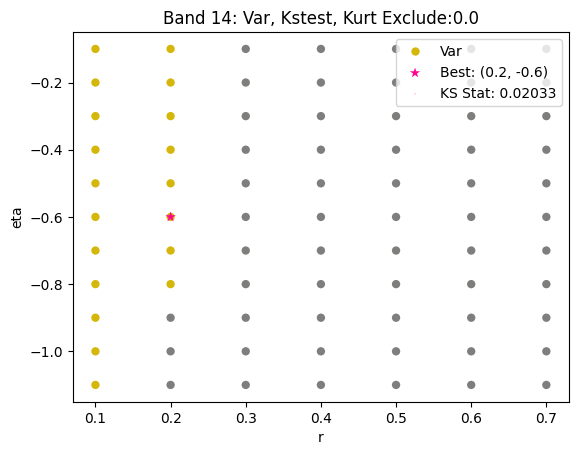

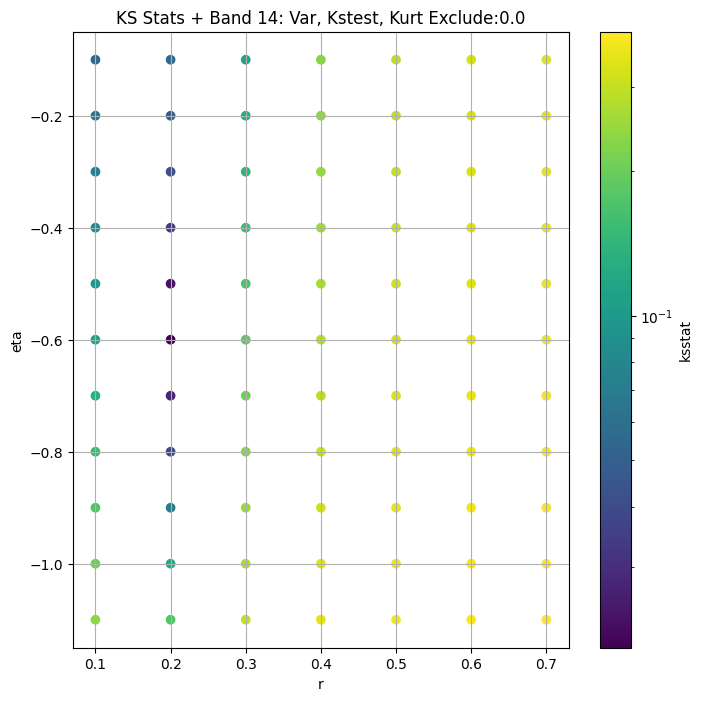

####
Band  18


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 0 0.017004380728414703 69343190.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 25 0.01714213738678494 66933228.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 50 0.01855741120643392 65293108.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 75 0.01955367597999491 63926996.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 100 0.019016420745912588 62729452.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 150 0.01968024129660617 60665390.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 200 0.021342642710058465 58900210.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 250 0.020797223907783713 57343440.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 300 0.021703125323829675 55943776.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 350 0.02299445230152493 54667630.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 500 0.024301673066655927 51386464.0
Number of samples: 100000, Without approximation : 100000.0


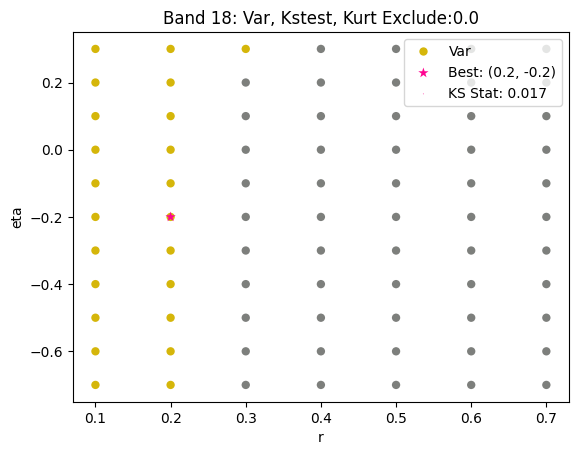

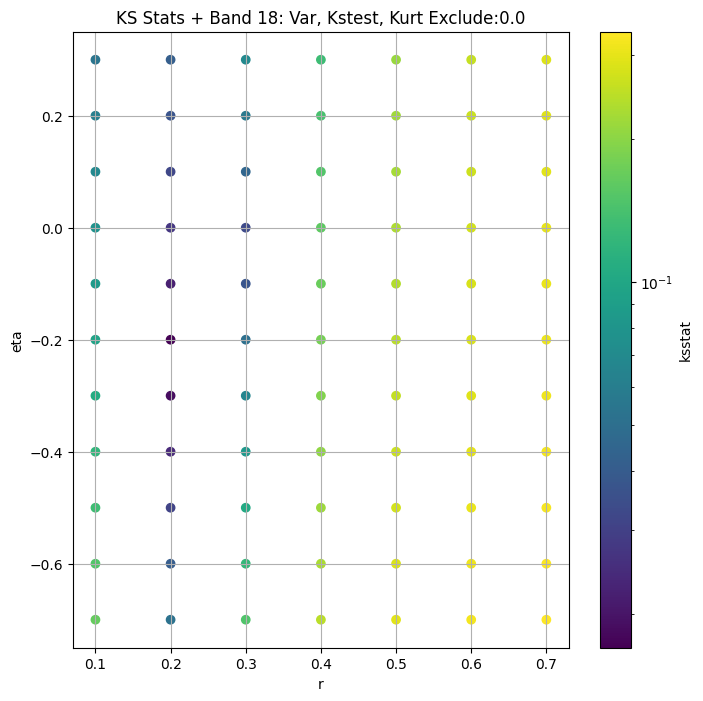

####
Band  21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 0 0.01770455584131163 29528264.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 25 0.017090159166489483 28220734.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 50 0.01656753454822424 27368110.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 75 0.01782921528568071 26667396.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 100 0.018963585174240682 26060056.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 150 0.020975049076609104 25029678.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 200 0.020464165853812943 24164836.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 250 0.02043992283036096 23415060.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 300 0.02183340604581009 22750168.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 350 0.02313767769372821 22151006.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 500 0.02358384247386293 20623392.0
Number of samples: 100000, Without approximation : 100000.0


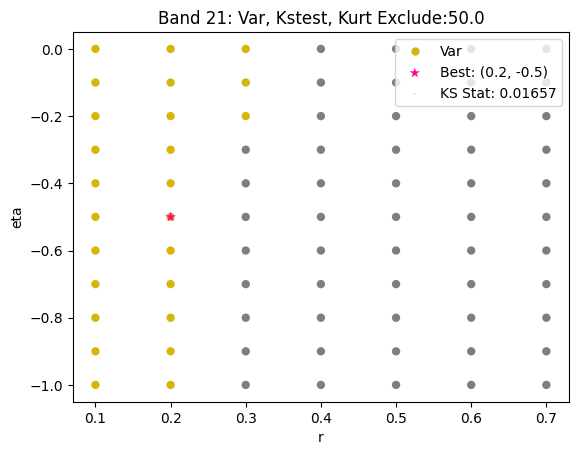

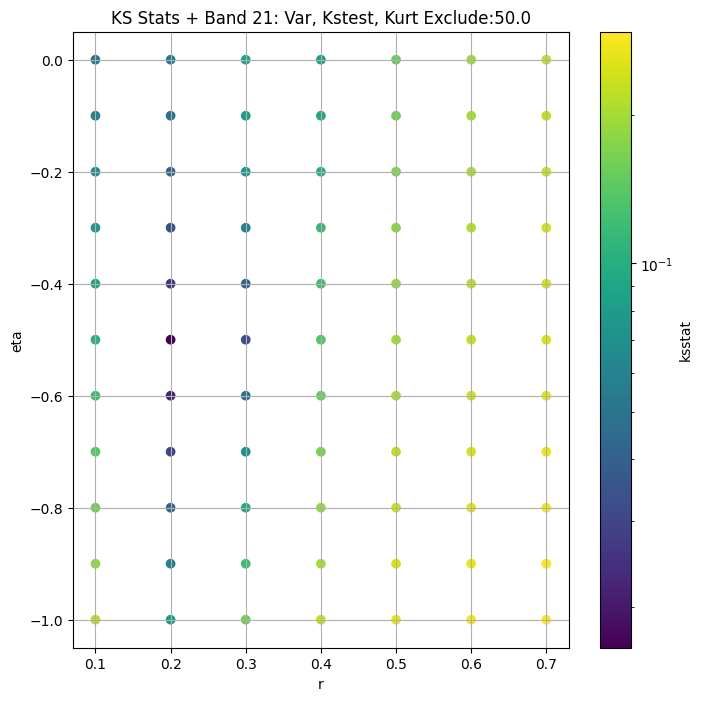

####
Band  24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 0 0.009125477195898624 11385378.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 25 0.00663718033277353 10449603.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 50 0.00890874815754128 9845965.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 75 0.01099163827250875 9368484.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 100 0.012909808376548648 8968661.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 150 0.015516127359030851 8318589.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 200 0.012617190044023063 7799567.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 250 0.013797253459130701 7367641.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 300 0.015779207126027733 6998612.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 350 0.017685278474344757 6677269.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 500 0.017706498511065698 5909514.0
Number of samples: 100000, Without approximation : 100000.0


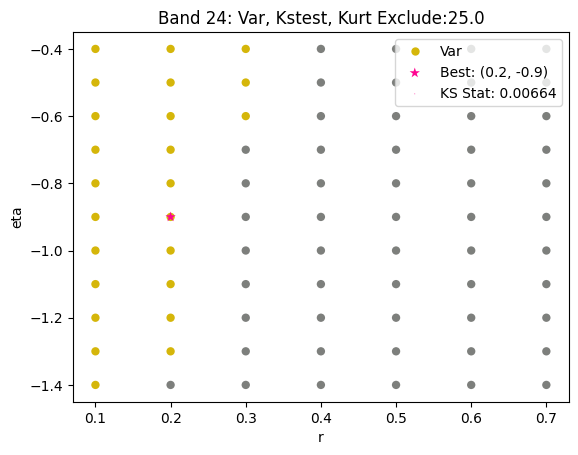

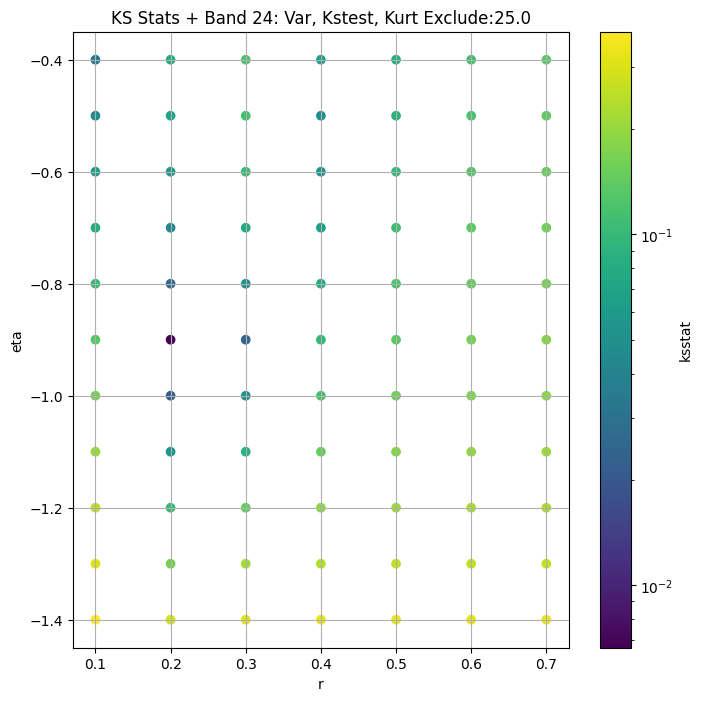

####
Band  27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 0 0.012282237839790544 4082310.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 25 0.012282237839790544 3575558.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 50 0.012282237839790544 3268643.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 75 0.012282237839790544 3036272.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 100 0.012282237839790544 2848078.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 150 0.012282237839790544 2553946.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 200 0.012282237839790544 2328953.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 250 0.012282237839790544 2148212.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 300 0.012282237839790544 1998264.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 350 0.012282237839790544 1870978.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 500 0.012226729758175403 1579553.8
Number of samples: 100000, Without approximation : 100000.0


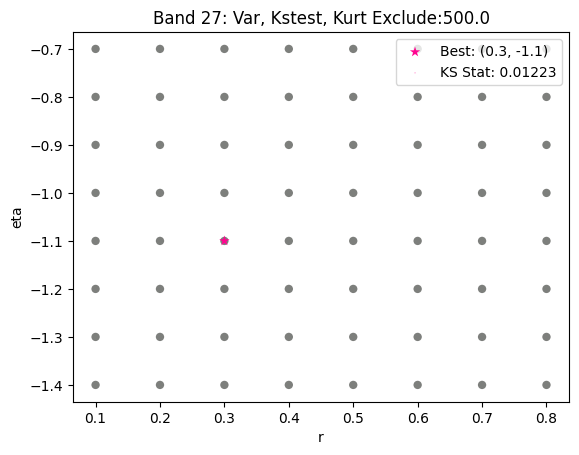

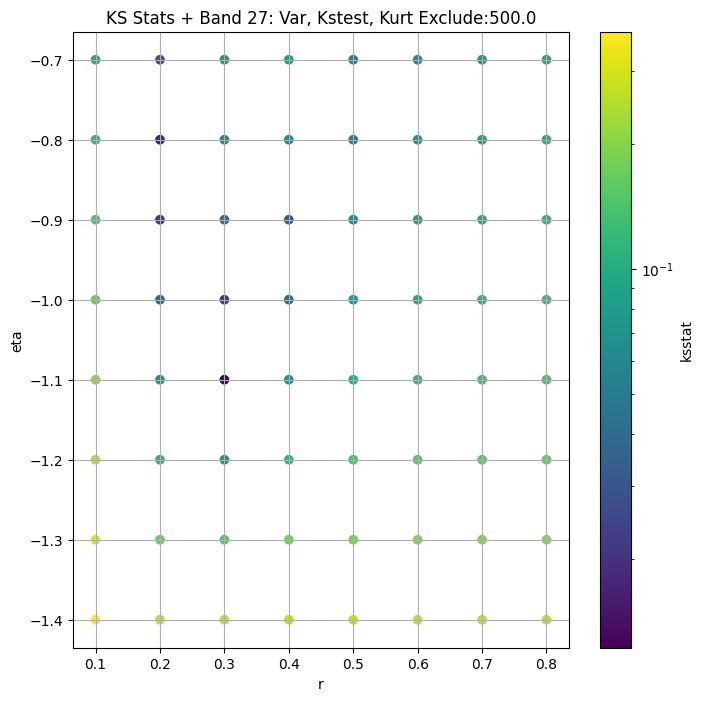

####
Band  31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 0 0.034059148166224906 140923.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 25 0.03425817045450963 115577.27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 50 0.034128213872372526 103352.77


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 75 0.03402559886078338 94506.46


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 100 0.03393659425087381 87601.96


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 150 0.03399980860180685 77239.414


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 200 0.03511272677012289 69619.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 250 0.034983437181080435 63670.234


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 300 0.034877000322277696 58844.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 350 0.03478120686010544 54816.03


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 500 0.03454283569585326 45766.207
Number of samples: 100000, Without approximation : 100000.0


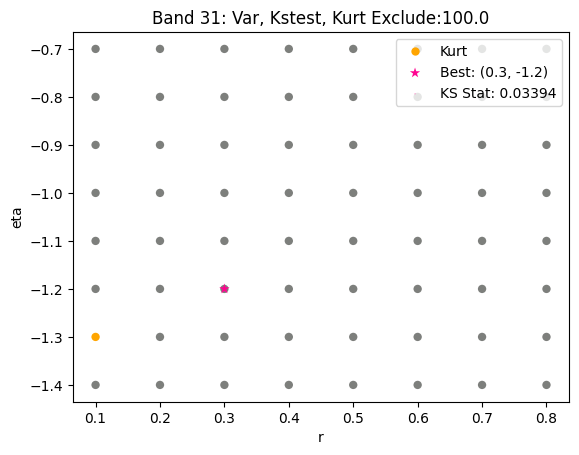

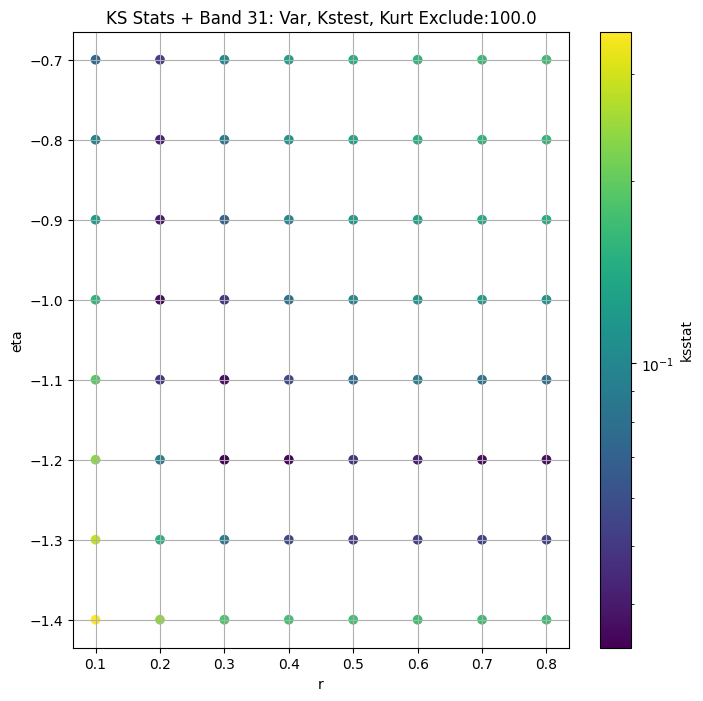

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     9.336108e+08  8.401879e+08  1.032820e+09   13.948858   11.880588   
5     2.283666e+09  2.135150e+09  2.436663e+09    4.631856    4.062694   
8     1.704543e+09  1.595908e+09  1.816450e+09    4.383642    3.860077   
11    1.321304e+09  1.240478e+09  1.403715e+09    3.787782    3.411390   
14    3.543411e+08  3.241691e+08  3.857620e+08    9.472601    8.316524   
18    6.934319e+07  6.348580e+07  7.567561e+07    9.638128    7.366555   
21    2.952826e+07  2.662045e+07  3.271980e+07   13.813057   10.137962   
24    1.138538e+07  9.675729e+06  1.334888e+07   37.156307   26.229534   
27    4.082310e+06  3.265270e+06  5.048213e+06   69.656845   46.320540   
31    1.409234e+05  1.055836e+05  1.967107e+05  147.243120   60.025883   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      16.470263       100000.0             0.021481        0.1         -0.2   
5       5.248331       100000.0             0.034436        0.2         -0.3   
8       4.927763       100000.0             0.023430        0.2          0.2   
11      4.184121       100000.0             0.026291        0.2         -0.1   
14     10.697055       100000.0             0.020326        0.2         -0.6   
18     12.757142       100000.0             0.017004        0.2         -0.2   
21     19.820702       100000.0             0.016568        0.2         -0.5   
24     51.107258       100000.0             0.006637        0.2         -0.9   
27     98.562770       100000.0             0.012227        0.3         -1.1   
31    424.687560       100000.0             0.033937        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000398                     0.0        9.336108e+08   
5      74320.601058                    25.0        2.247455e+09   
8      13439.221510                    75.0        1.638000e+09   
11     23833.038961                     0.0        1.321304e+09   
14     34550.374990                     0.0        3.543411e+08   
18      1677.634617                     0.0        6.934319e+07   
21      1810.060185                    50.0        2.736811e+07   
24      4146.667857                    25.0        1.044960e+07   
27     95878.616477                   500.0        1.579554e+06   
31      9459.715299                   100.0        8.760196e+04   

      kstest_stat_cutoff_0.05  
band                           
2                    0.004293  
5                    0.004293  
8                    0.004293  
11                   0.004293  
14                   0.004293  
18                   0.004293  
21                   0.004293  
24                   0.004293  
27                   0.004293  
31                   0.004293

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.021514302824942377, var: 838933440.0


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.02094067835416291, var: 857686080.0


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.020719647561154055, var: 878406976.0


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.020029887844346977, var: 902089472.0


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.019865425291855865, var: 933610816.0
Number of samples: 100000, Without approximation : 100000.0


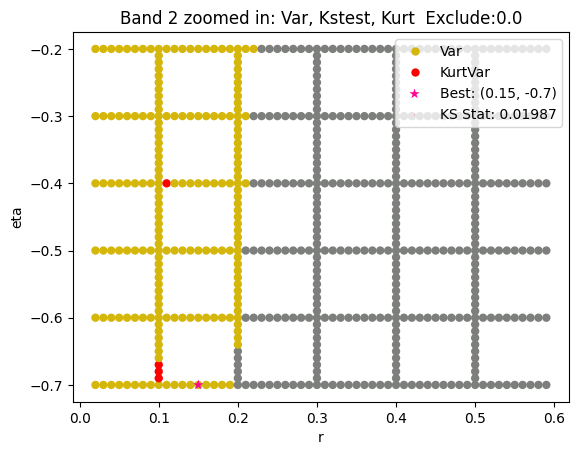

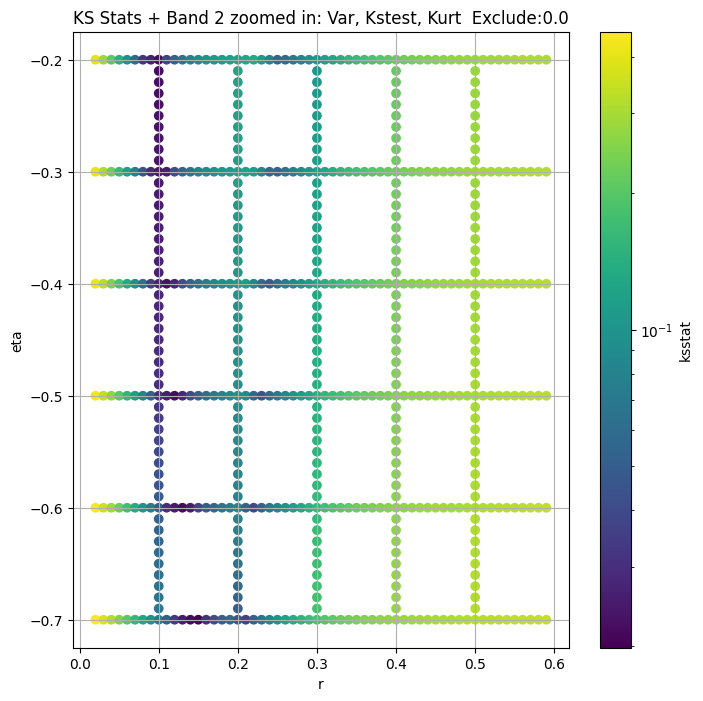

Band 5


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 5, 25.0 + 100 = 125, ksstat: 0.035597315357133175, var: 2142303488.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 5, 25.0 + 75 = 100, ksstat: 0.03535989978533098, var: 2165745152.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 5, 25.0 + 50 = 75, ksstat: 0.03509565324920316, var: 2190708992.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 5, 25.0 + 25 = 50, ksstat: 0.03479455206803961, var: 2217634816.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 5, 25.0 + 0 = 25, ksstat: 0.03443574082172329, var: 2247454976.0


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
band 5, 25.0 + -25 = 0, ksstat: 0.03409008640472416, var: 2283666176.0
Number of samples: 100000, Without approximation : 100000.0


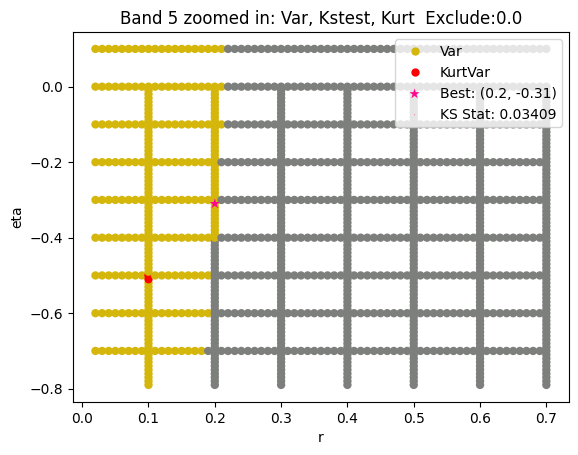

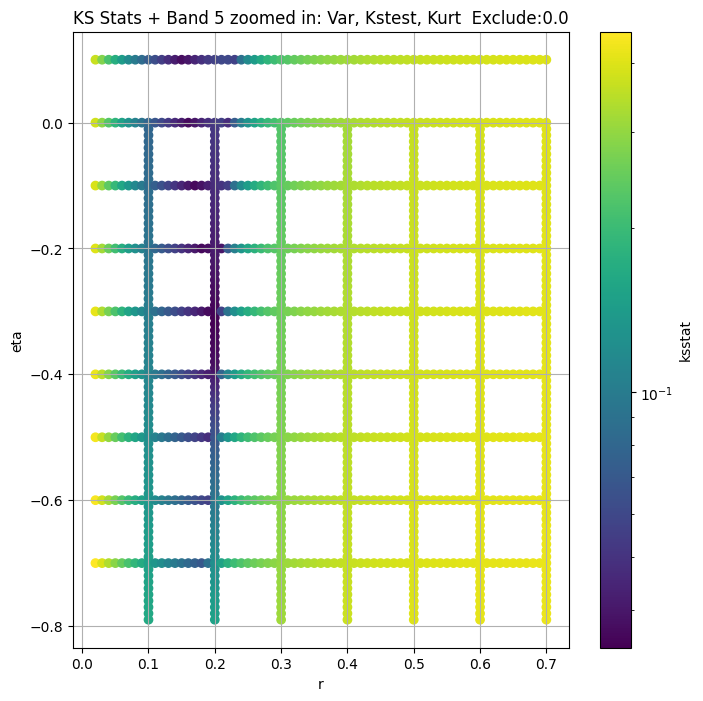

Band 8


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 8, 75.0 + 100 = 175, ksstat: 0.02389695962039451, var: 1569674496.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 8, 75.0 + 75 = 150, ksstat: 0.024169757294428384, var: 1585463552.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 8, 75.0 + 50 = 125, ksstat: 0.02445768551970534, var: 1602014592.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 8, 75.0 + 25 = 100, ksstat: 0.02404985950116445, var: 1619459072.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 8, 75.0 + 0 = 75, ksstat: 0.023378706787712797, var: 1637999616.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 8, 75.0 + -25 = 50, ksstat: 0.022977284473395948, var: 1657928960.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 8, 75.0 + -50 = 25, ksstat: 0.022390942111110923, var: 1679683328.0


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
band 8, 75.0 + -75 = 0, ksstat: 0.022390942111110923, var: 1704543360.0
Number of samples: 100000, Without approximation : 100000.0


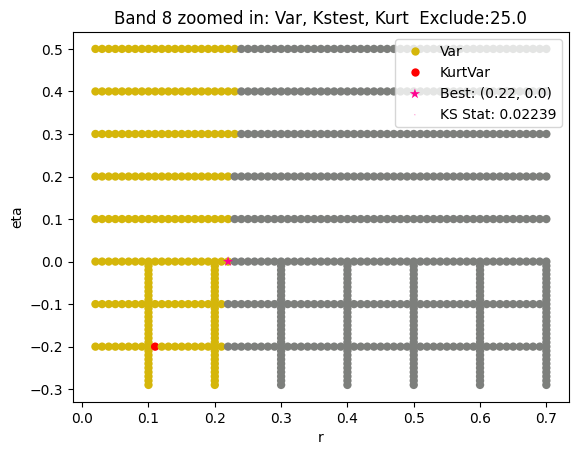

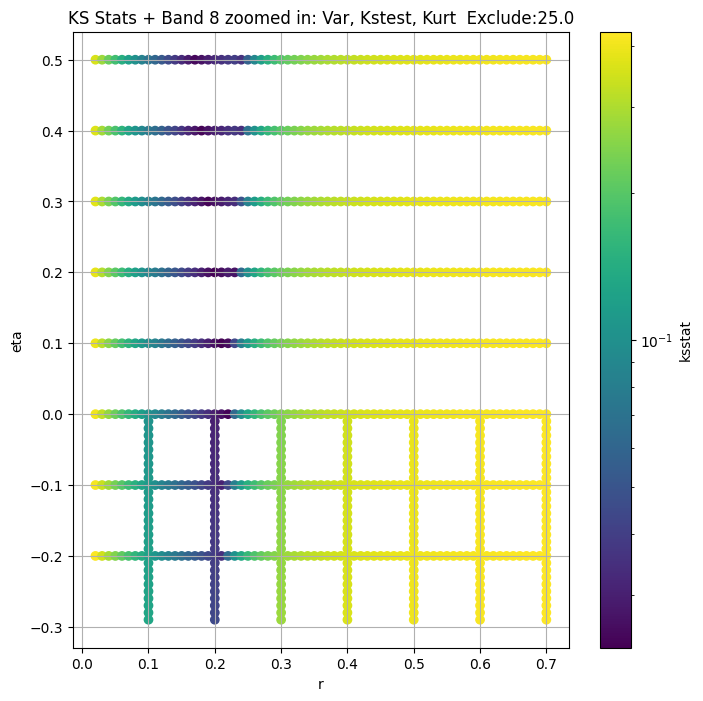

Band 11


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 11, 0.0 + 100 = 100, ksstat: 0.02726937133457602, var: 1268350336.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 11, 0.0 + 75 = 75, ksstat: 0.02699705251893622, var: 1280318080.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 11, 0.0 + 50 = 50, ksstat: 0.026706169588058604, var: 1292920064.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 11, 0.0 + 25 = 25, ksstat: 0.026389095853284958, var: 1306351616.0


  0%|          | 0/999 [00:00<?, ?it/s]

Finding Minimum after computing 999 CDFs
band 11, 0.0 + 0 = 0, ksstat: 0.026215702960128706, var: 1321303680.0
Number of samples: 100000, Without approximation : 100000.0


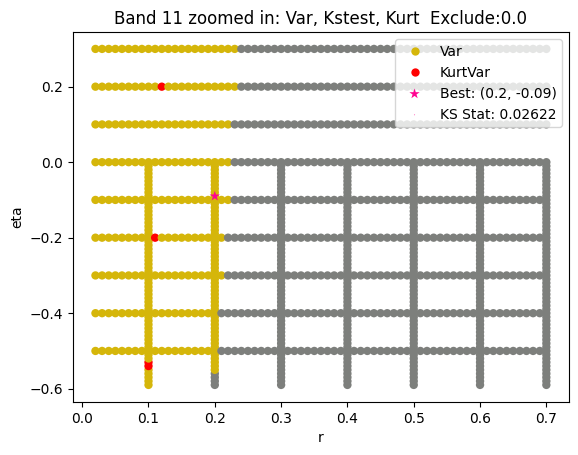

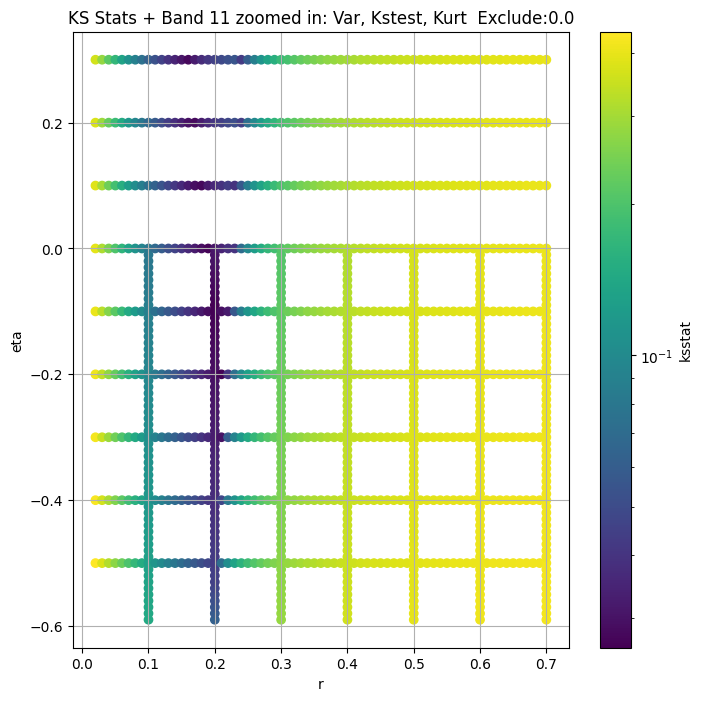

Band 14


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 100 = 100, ksstat: 0.019752137686494087, var: 326499488.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 75 = 75, ksstat: 0.019397480843868442, var: 332357504.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 50 = 50, ksstat: 0.019066563109890744, var: 338728640.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 25 = 25, ksstat: 0.018111171579567653, var: 345833472.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 0 = 0, ksstat: 0.017909931279772362, var: 354341088.0
Number of samples: 100000, Without approximation : 100000.0


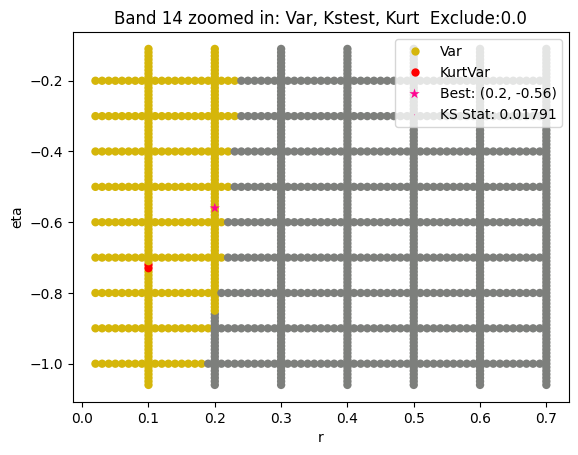

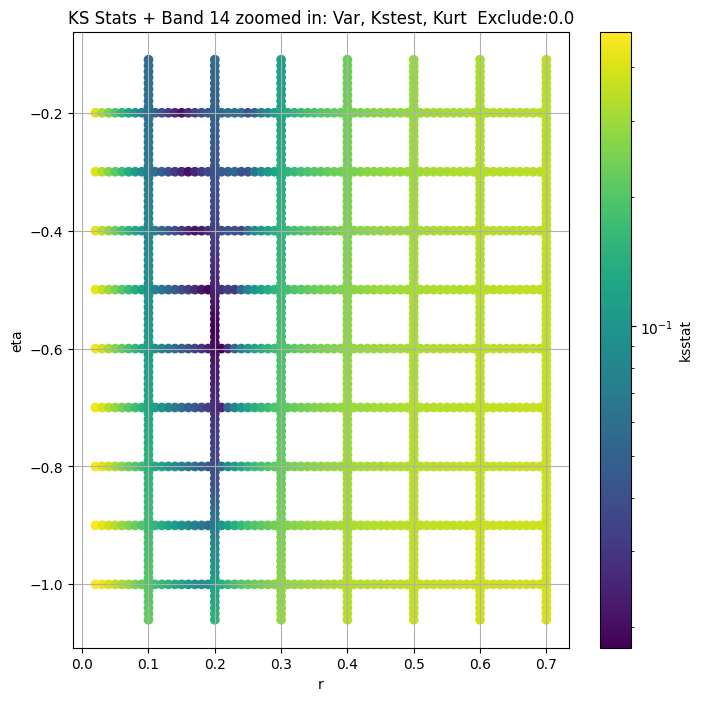

Band 18


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 100 = 100, ksstat: 0.017062059785624917, var: 62729452.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 75 = 75, ksstat: 0.017049662844924818, var: 63926996.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 50 = 50, ksstat: 0.015866480829839325, var: 65293108.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 25 = 25, ksstat: 0.016164544745429887, var: 66933228.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 0.0 + 0 = 0, ksstat: 0.014158227806813972, var: 69343192.0
Number of samples: 100000, Without approximation : 100000.0


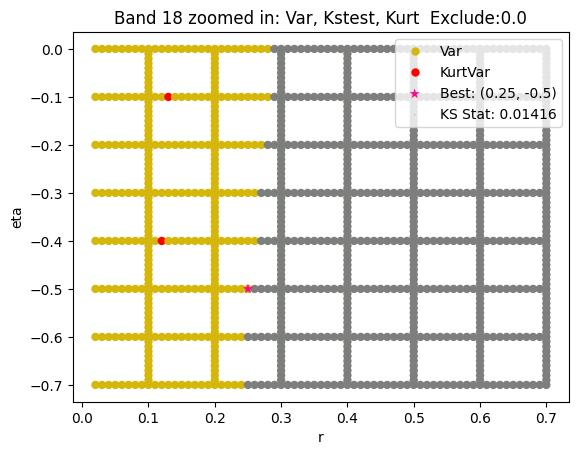

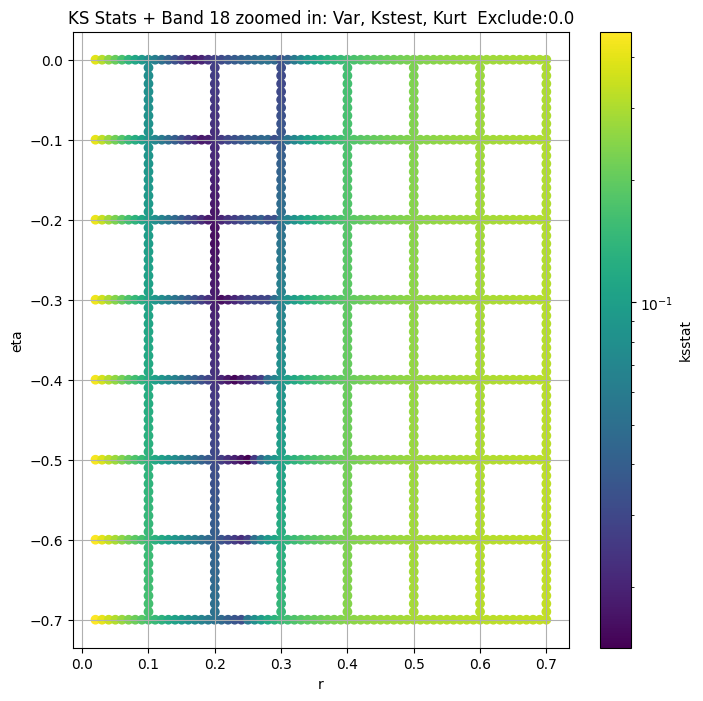

Band 21


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + 100 = 150, ksstat: 0.01600963718779848, var: 25029678.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + 75 = 125, ksstat: 0.016220906798596557, var: 25519450.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + 50 = 100, ksstat: 0.015932499925761387, var: 26060056.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + 25 = 75, ksstat: 0.014830001617935754, var: 26667396.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + 0 = 50, ksstat: 0.015215003162396656, var: 27368110.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + -25 = 25, ksstat: 0.014187413906101967, var: 28220734.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 50.0 + -50 = 0, ksstat: 0.014151040516154123, var: 29528264.0
Number of samples: 100000, Without approximation : 100000.0


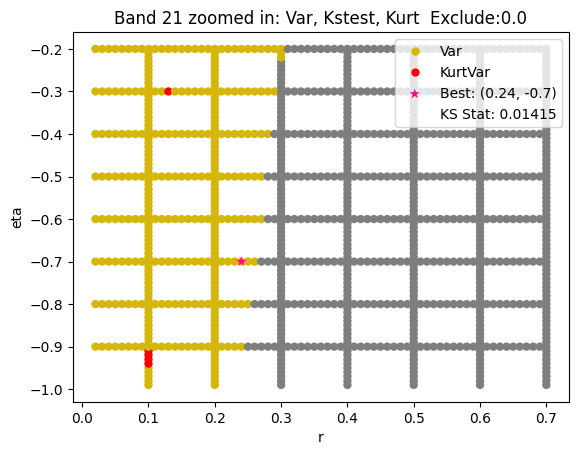

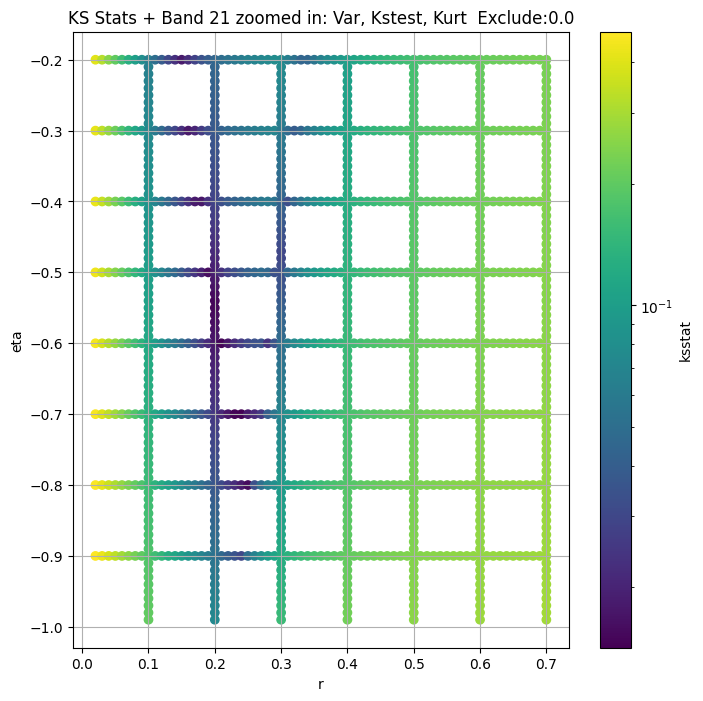

Band 24


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 25.0 + 100 = 125, ksstat: 0.007814536813218413, var: 8623118.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 25.0 + 75 = 100, ksstat: 0.007107432631754916, var: 8968661.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 25.0 + 50 = 75, ksstat: 0.0073473378692080205, var: 9368484.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 25.0 + 25 = 50, ksstat: 0.005747791970251548, var: 9845965.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 25.0 + 0 = 25, ksstat: 0.005674808478894025, var: 10449603.0


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
band 24, 25.0 + -25 = 0, ksstat: 0.00489587436858048, var: 11385378.0
Number of samples: 100000, Without approximation : 100000.0


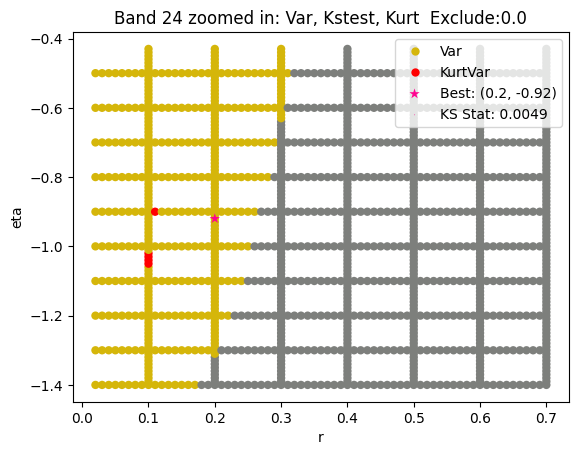

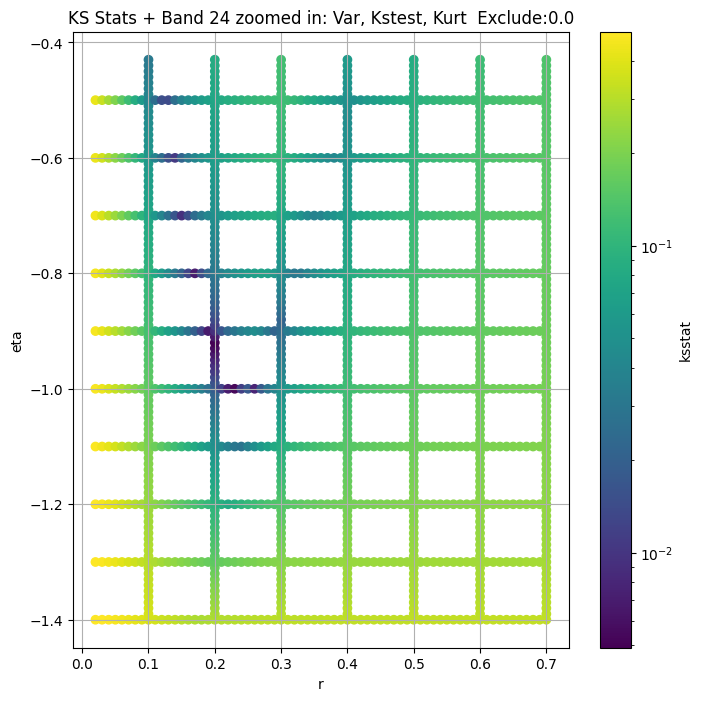

Band 27


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + 100 = 600, ksstat: 0.012805536334521528, var: 1434755.875


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + 75 = 575, ksstat: 0.012598549139894333, var: 1468222.25


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + 50 = 550, ksstat: 0.012394867090814221, var: 1503394.375


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + 25 = 525, ksstat: 0.012427429822408742, var: 1540439.875


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + 0 = 500, ksstat: 0.012226729758175403, var: 1579553.75


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + -25 = 475, ksstat: 0.012260803308999257, var: 1620928.375


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + -50 = 450, ksstat: 0.011870886486978816, var: 1664778.75


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + -75 = 425, ksstat: 0.011584233501966357, var: 1711366.0


  0%|          | 0/1163 [00:00<?, ?it/s]

Finding Minimum after computing 1163 CDFs
band 27, 500.0 + -100 = 400, ksstat: 0.011620171238962473, var: 1761007.125
Number of samples: 100000, Without approximation : 100000.0


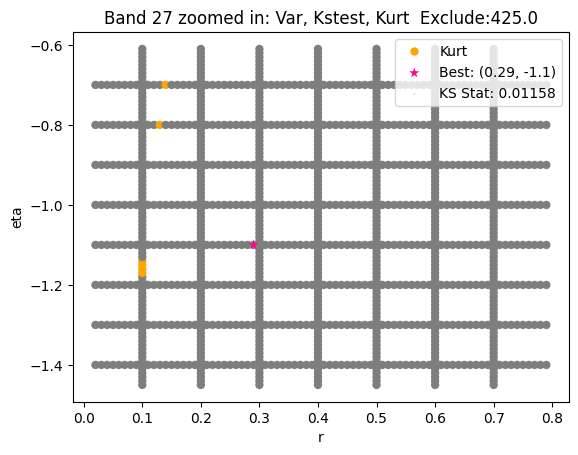

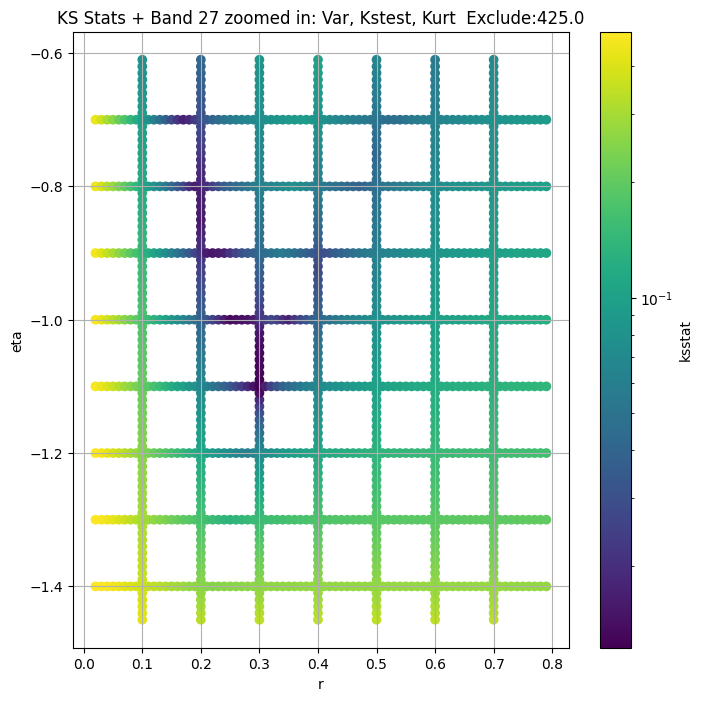

Band 31


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + 100 = 200, ksstat: 0.030387513765877394, var: 69619.46875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + 75 = 175, ksstat: 0.030387513765877394, var: 73171.8671875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + 50 = 150, ksstat: 0.030387513765877394, var: 77239.4140625


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + 25 = 125, ksstat: 0.030387513765877394, var: 81972.2109375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + 0 = 100, ksstat: 0.030387513765877394, var: 87601.9609375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + -25 = 75, ksstat: 0.030387513765877394, var: 94506.4609375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + -50 = 50, ksstat: 0.030387513765877394, var: 103352.7734375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + -75 = 25, ksstat: 0.030264337436679556, var: 115577.2734375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 100.0 + -100 = 0, ksstat: 0.030387513765877394, var: 140923.4375
Number of samples: 100000, Without approximation : 100000.0


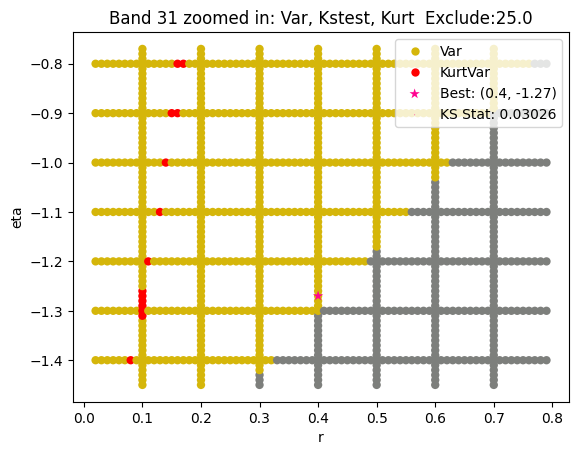

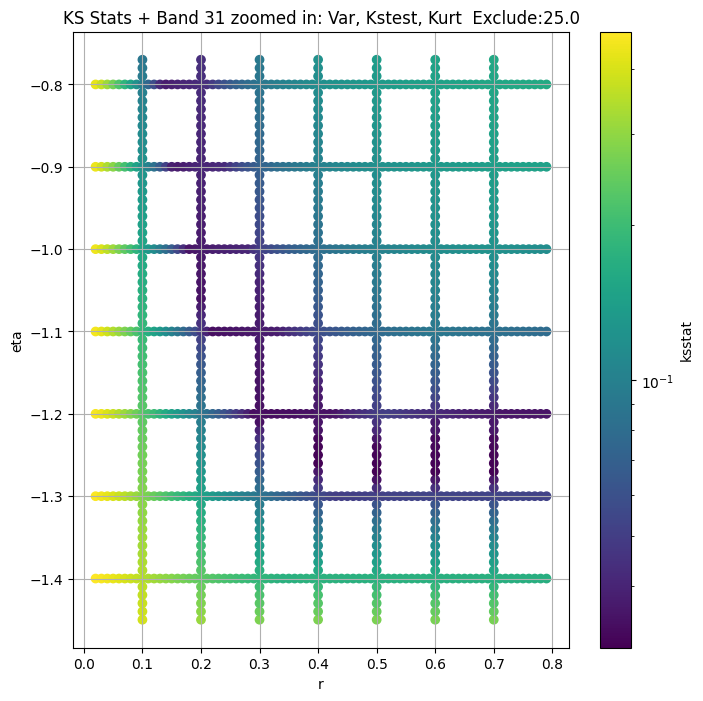

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     9.336108e+08  8.401879e+08  1.032820e+09   13.948858   11.880588   
5     2.283666e+09  2.135150e+09  2.436663e+09    4.631856    4.062694   
8     1.704543e+09  1.595908e+09  1.816450e+09    4.383642    3.860077   
11    1.321304e+09  1.240478e+09  1.403715e+09    3.787782    3.411390   
14    3.543411e+08  3.241691e+08  3.857620e+08    9.472601    8.316524   
18    6.934319e+07  6.348580e+07  7.567561e+07    9.638128    7.366555   
21    2.952826e+07  2.662045e+07  3.271980e+07   13.813057   10.137962   
24    1.138538e+07  9.675729e+06  1.334888e+07   37.156307   26.229534   
27    4.082310e+06  3.265270e+06  5.048213e+06   69.656845   46.320540   
31    1.409234e+05  1.055836e+05  1.967107e+05  147.243120   60.025883   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      16.470263       100000.0             0.021481        0.1         -0.2   
5       5.248331       100000.0             0.034436        0.2         -0.3   
8       4.927763       100000.0             0.023430        0.2          0.2   
11      4.184121       100000.0             0.026291        0.2         -0.1   
14     10.697055       100000.0             0.020326        0.2         -0.6   
18     12.757142       100000.0             0.017004        0.2         -0.2   
21     19.820702       100000.0             0.016568        0.2         -0.5   
24     51.107258       100000.0             0.006637        0.2         -0.9   
27     98.562770       100000.0             0.012227        0.3         -1.1   
31    424.687560       100000.0             0.033937        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2          0.000398                     0.0        9.336108e+08   
5      74320.601058                    25.0        2.283666e+09   
8      13439.221510                    75.0        1.679683e+09   
11     23833.038961                     0.0        1.321304e+09   
14     34550.374990                     0.0        3.543411e+08   
18      1677.634617                     0.0        6.934319e+07   
21      1810.060185                    50.0        2.952826e+07   
24      4146.667857                    25.0        1.138538e+07   
27     95878.616477                   500.0        1.711366e+06   
31      9459.715299                   100.0        1.155773e+05   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.004293          0.019865    0.15     -0.70   
5                    0.004293          0.034090    0.20     -0.31   
8                    0.004293          0.022391    0.22      0.00   
11                   0.004293          0.026216    0.20     -0.09   
14                   0.004293          0.017910    0.20     -0.56   
18                   0.004293          0.014158    0.25     -0.50   
21                   0.004293          0.014151    0.24     -0.70   
24                   0.004293          0.004896    0.20     -0.92   
27                   0.004293          0.011584    0.29     -1.10   
31                   0.004293          0.030264    0.40     -1.27   

         best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                   
2        938.572912                  0.0         4687  
5      78004.131263                  0.0         1562  
8     100000.000000                 25.0         3514  
11     23165.449318                  0.0         2635  
14     29468.906460                  0.0         5931  
18     82551.419048                  0.0         9375  
21     43839.149382                  0.0         9375  
24      5046.469661    

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

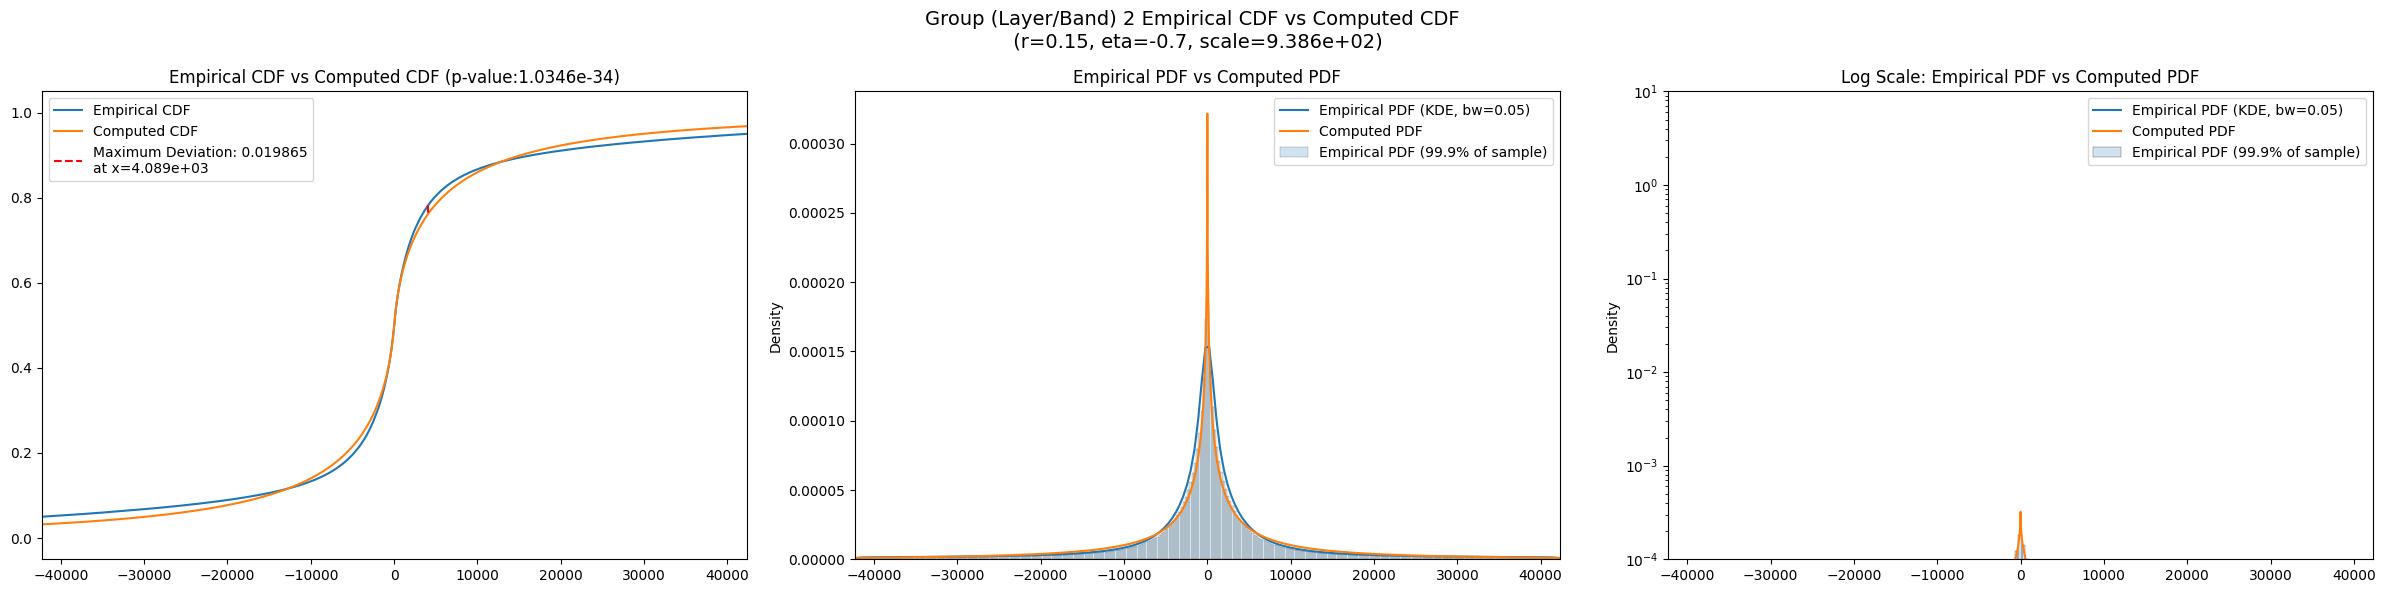

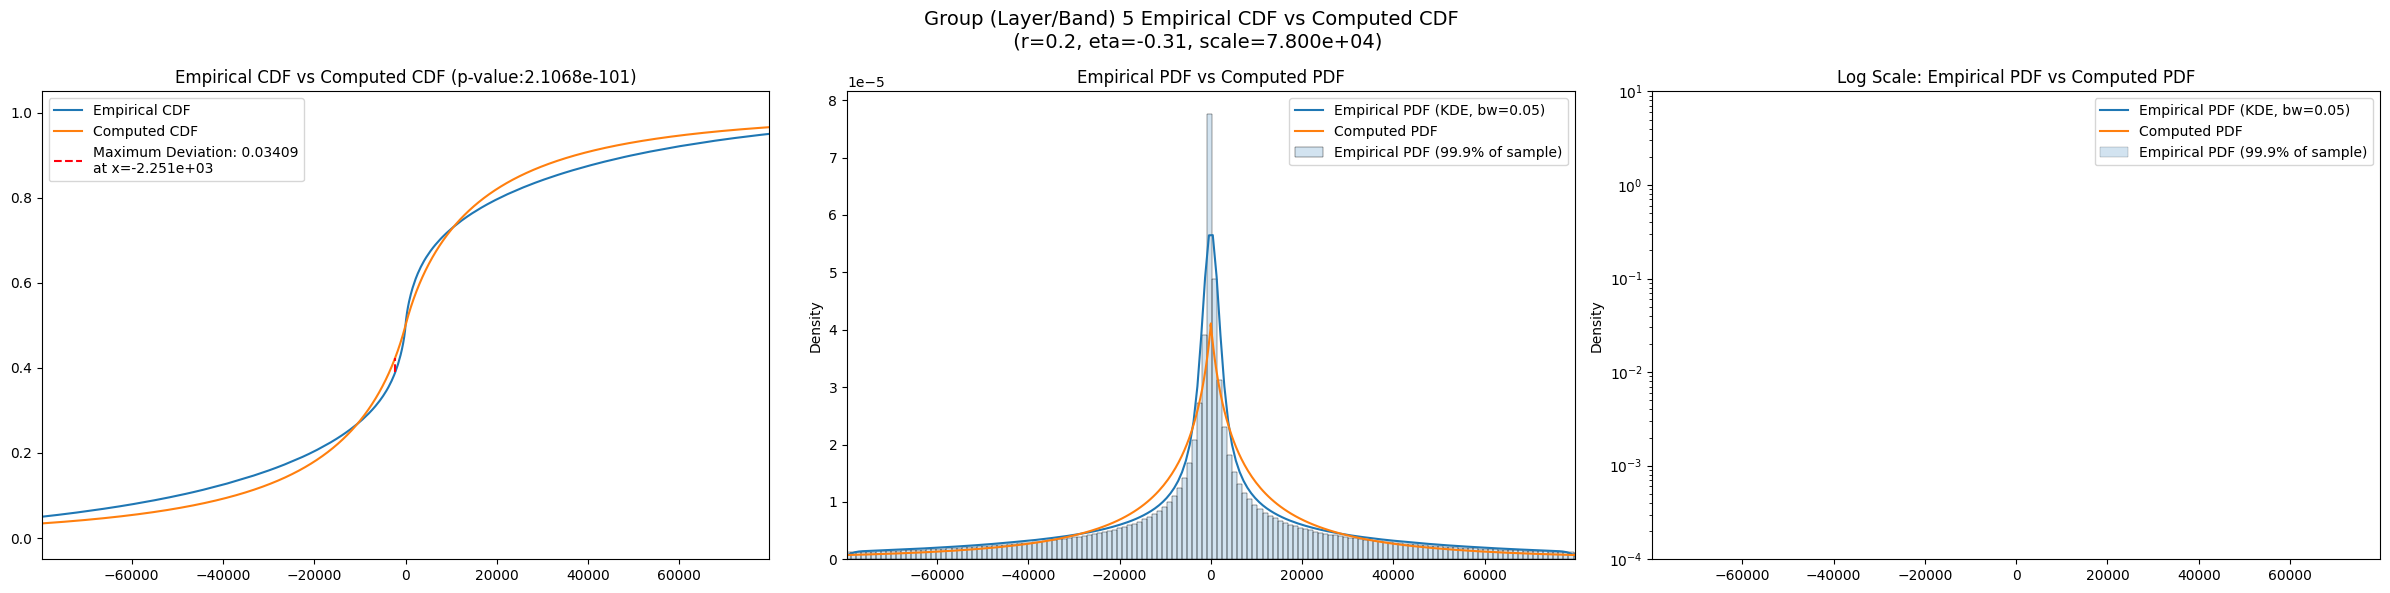

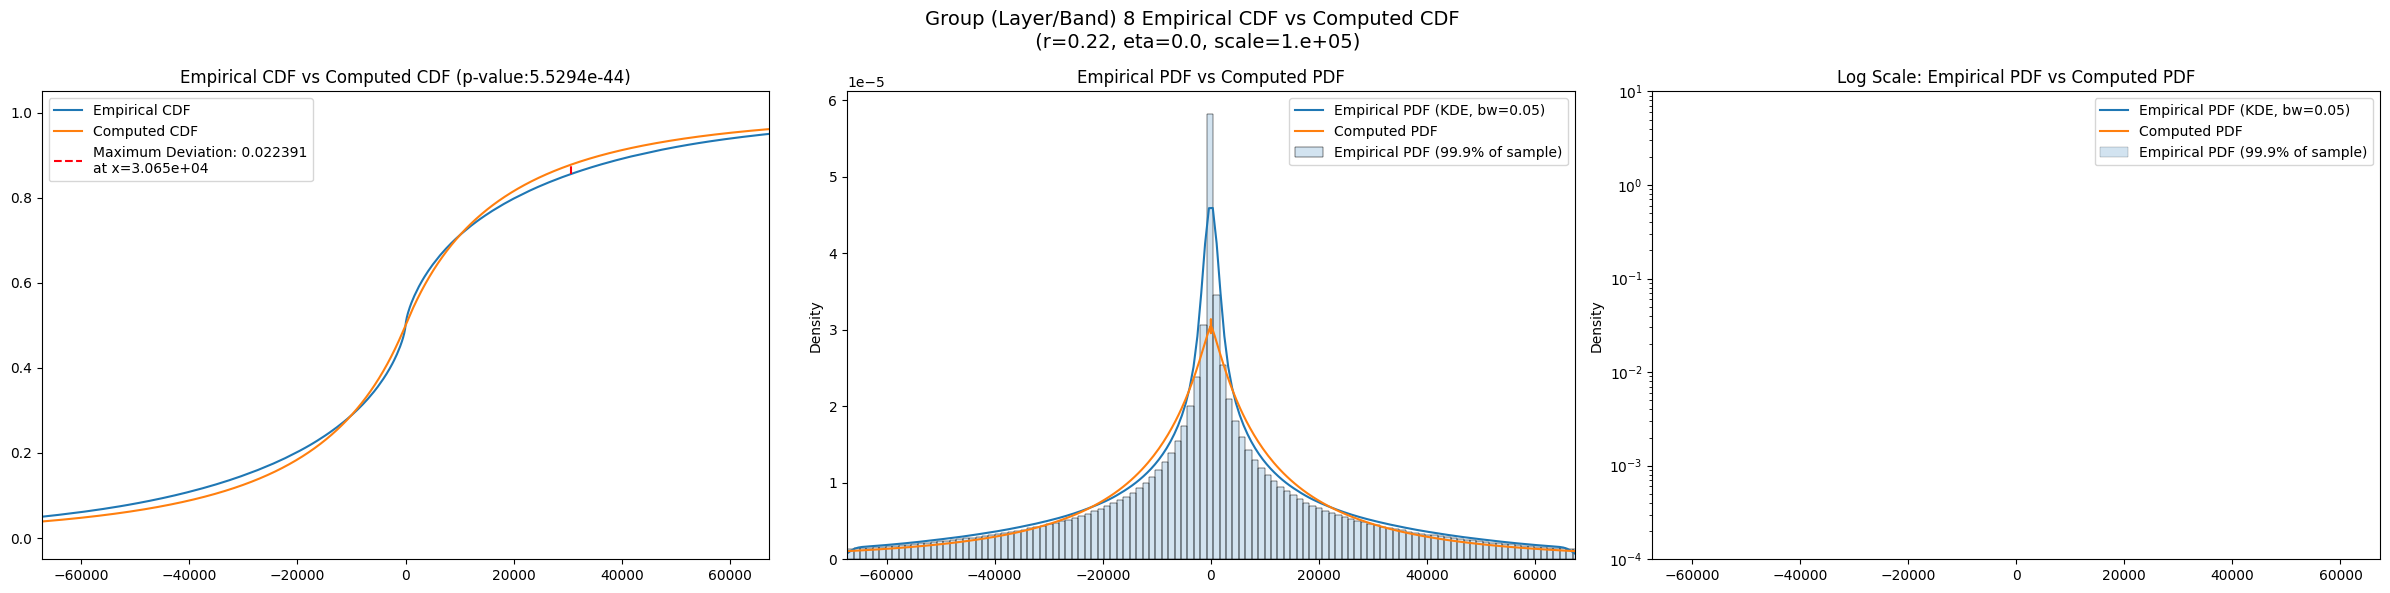

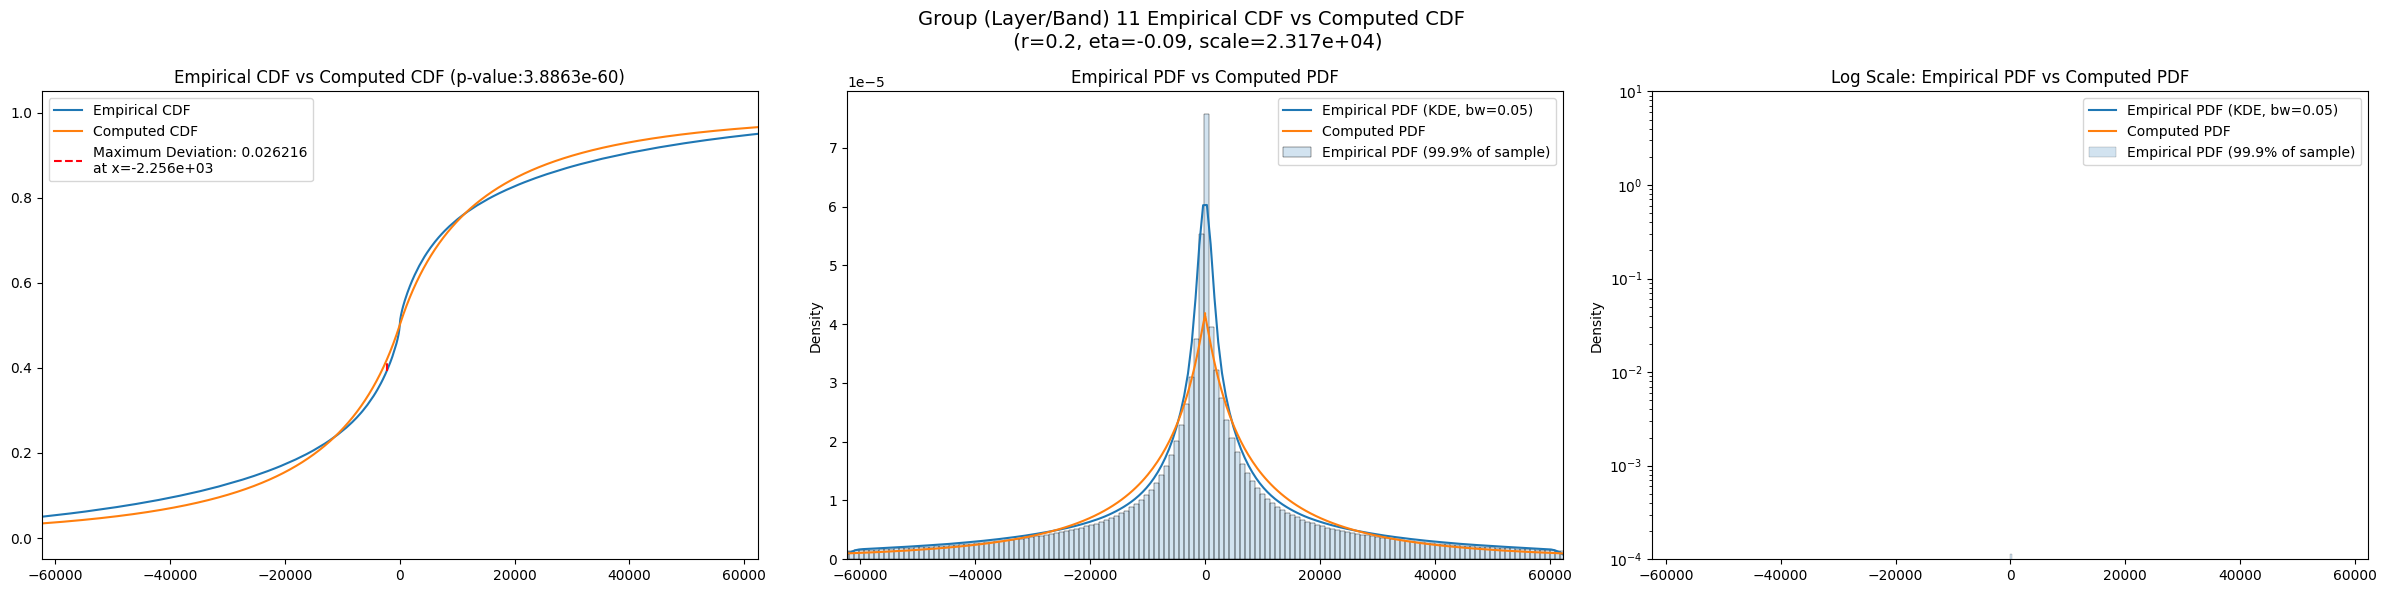

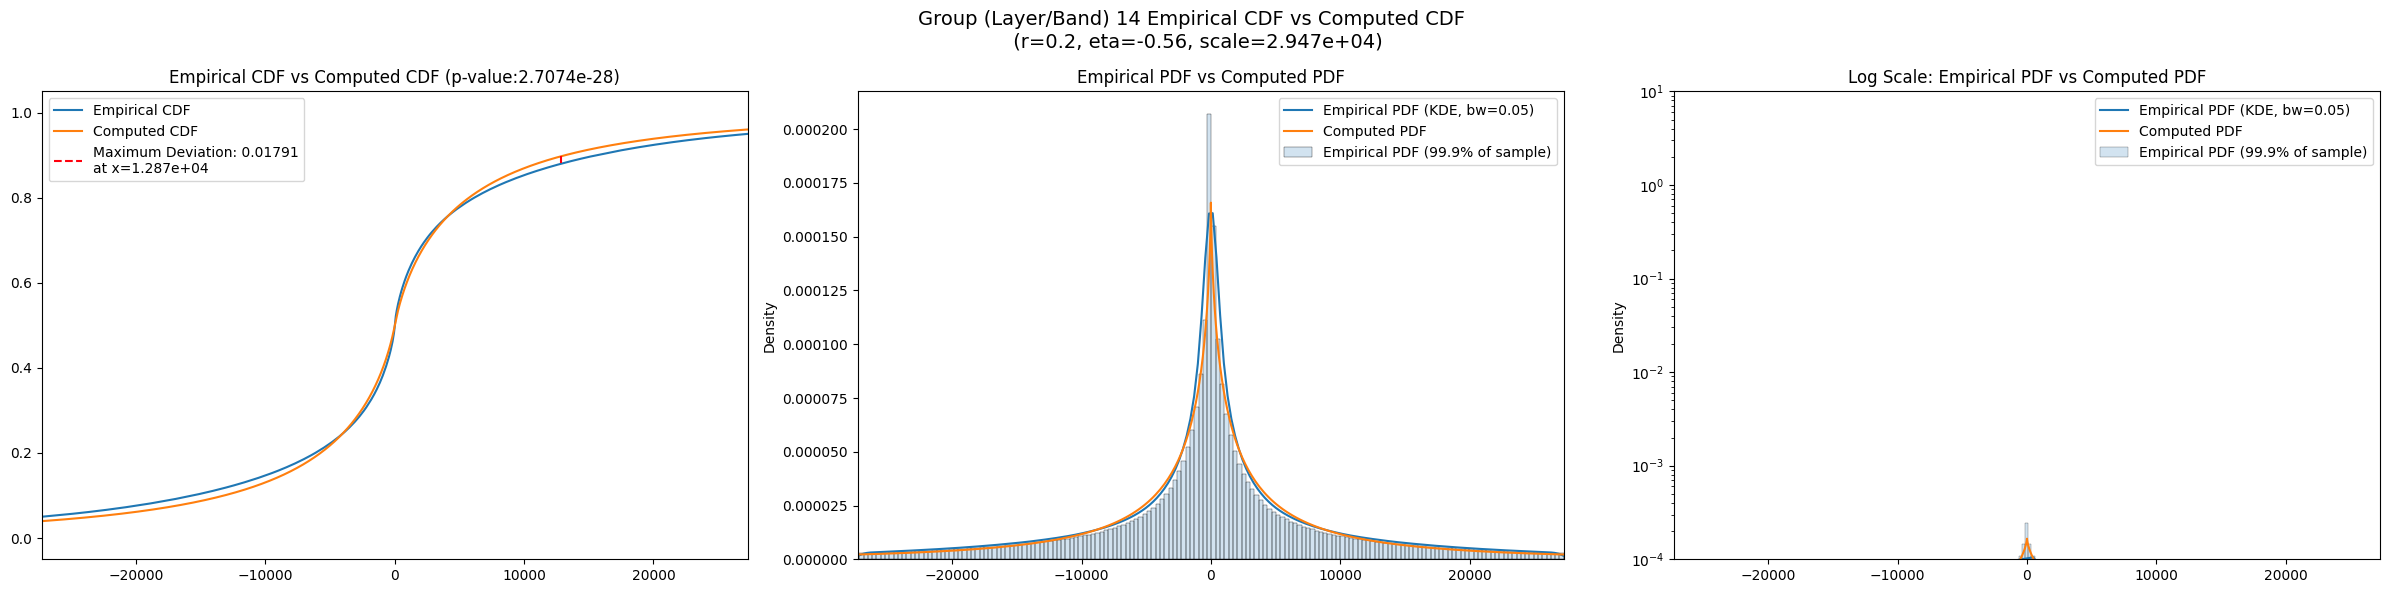

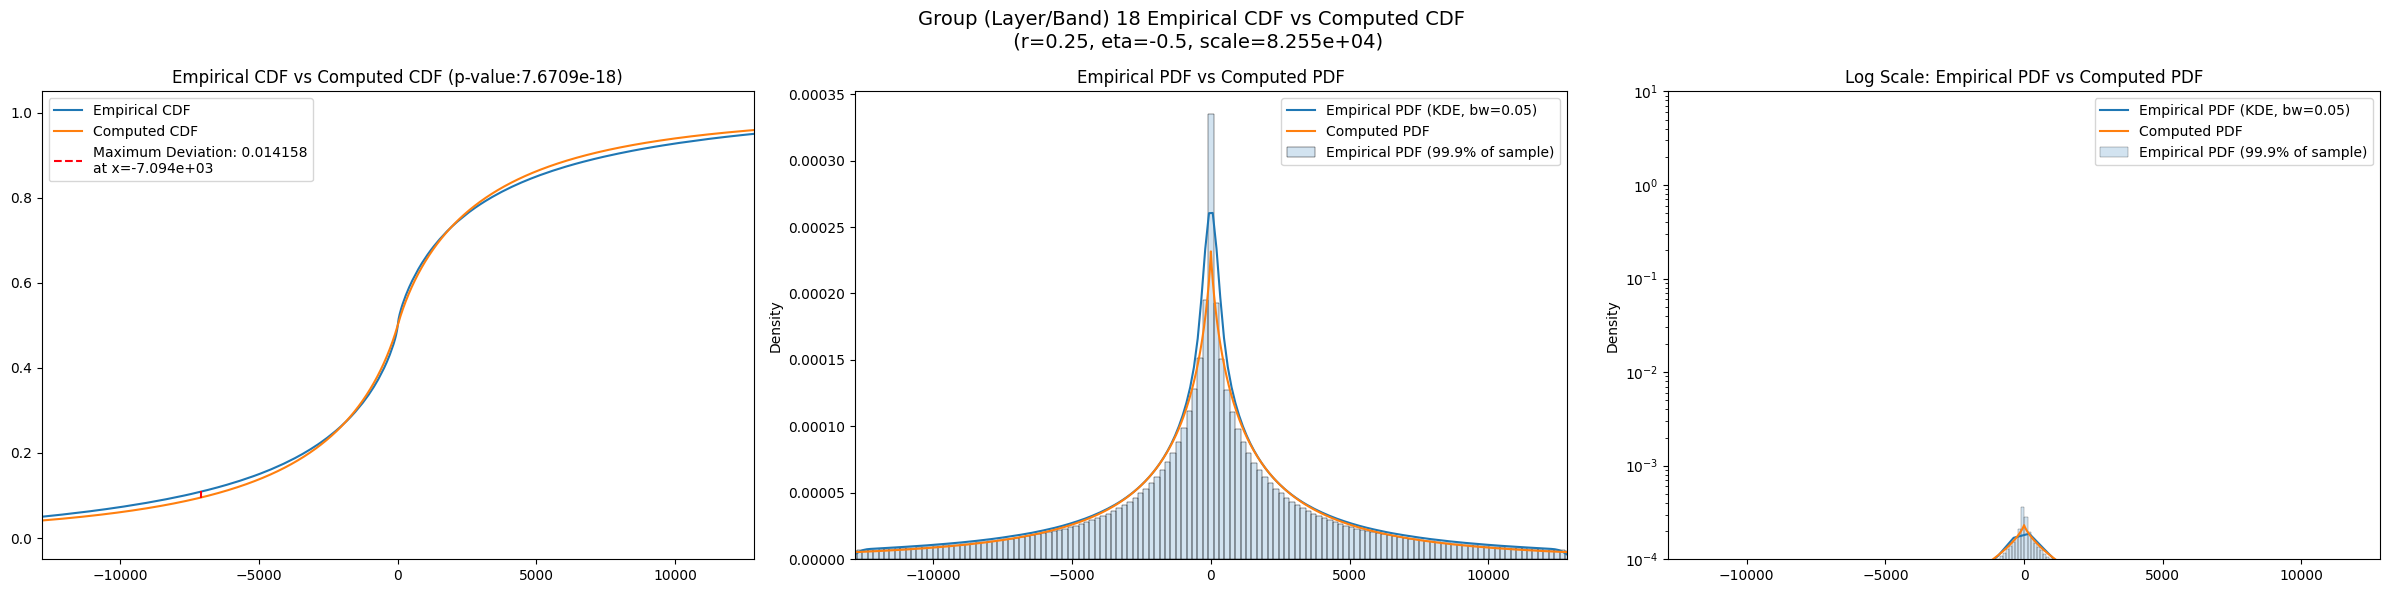

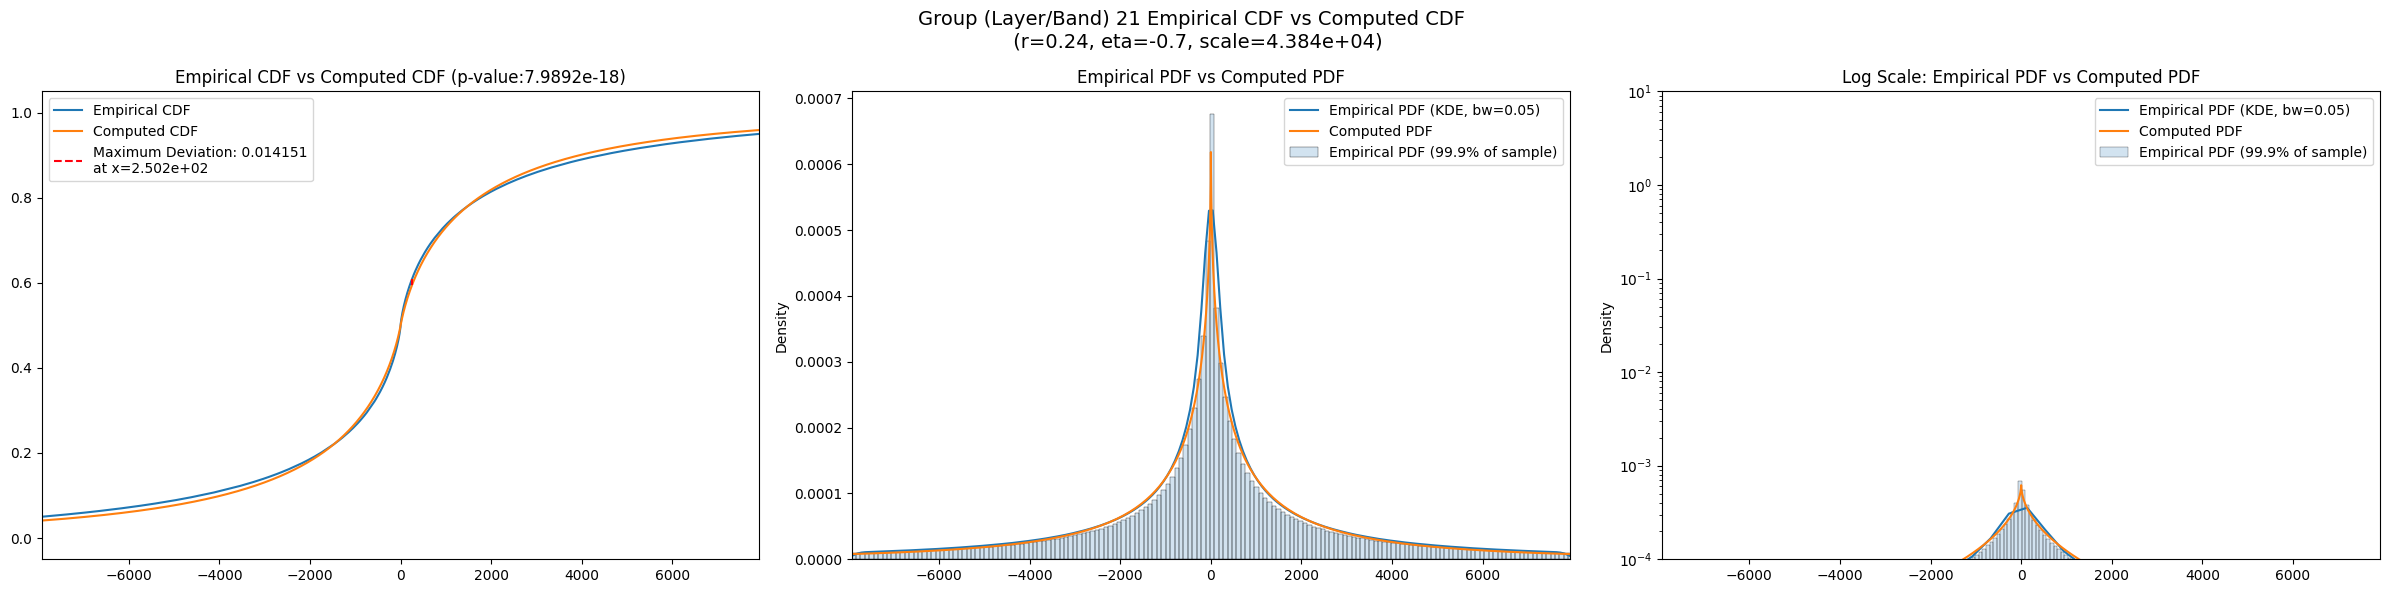

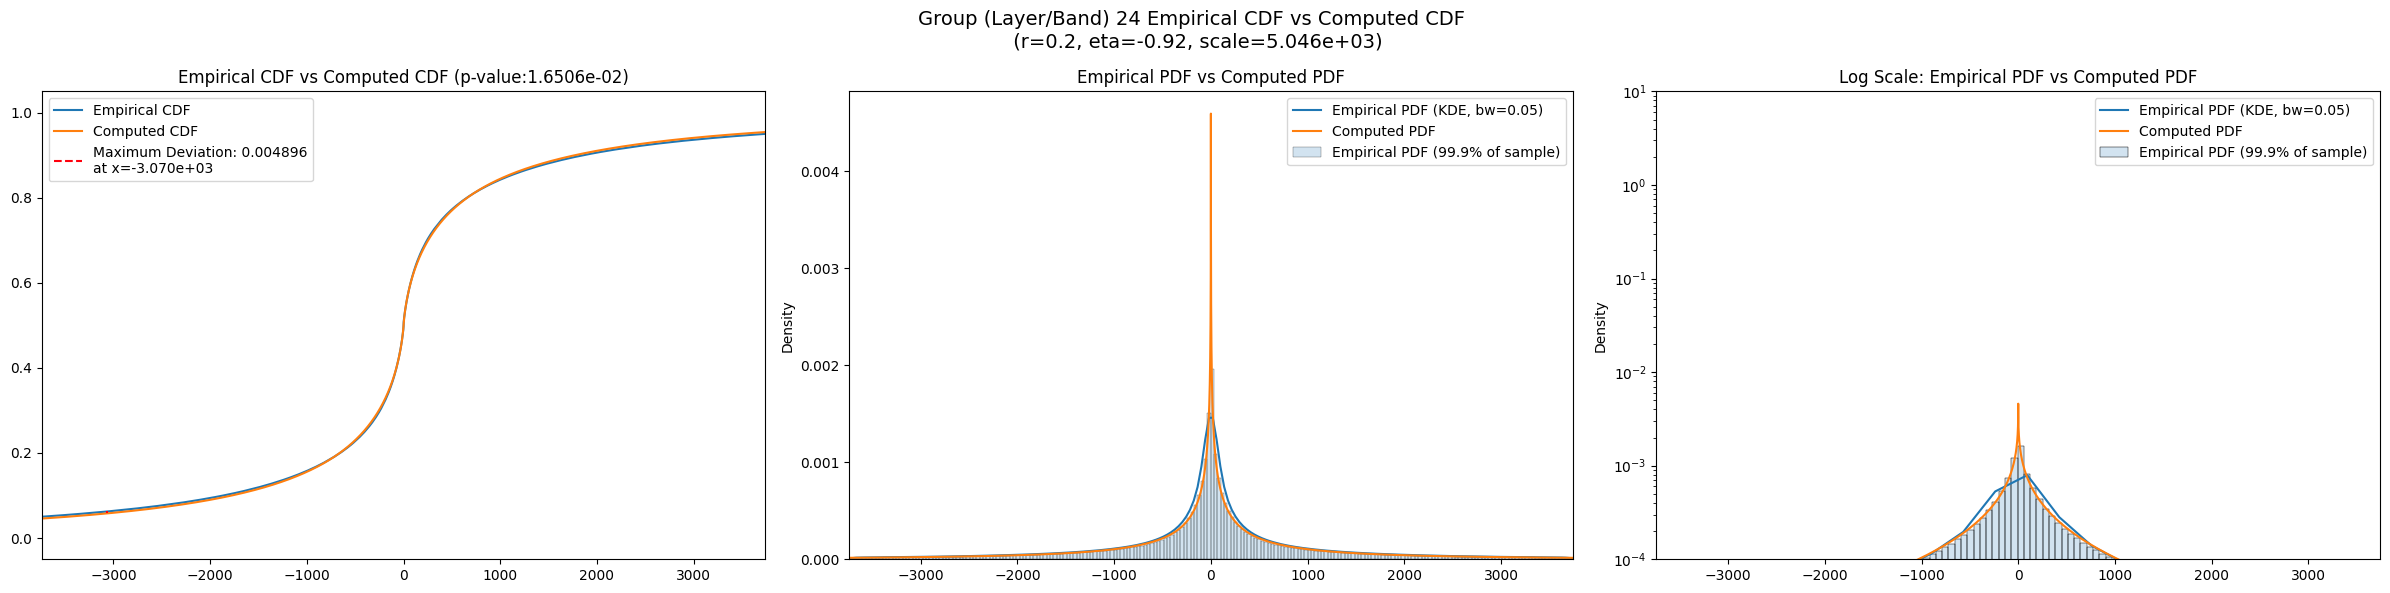

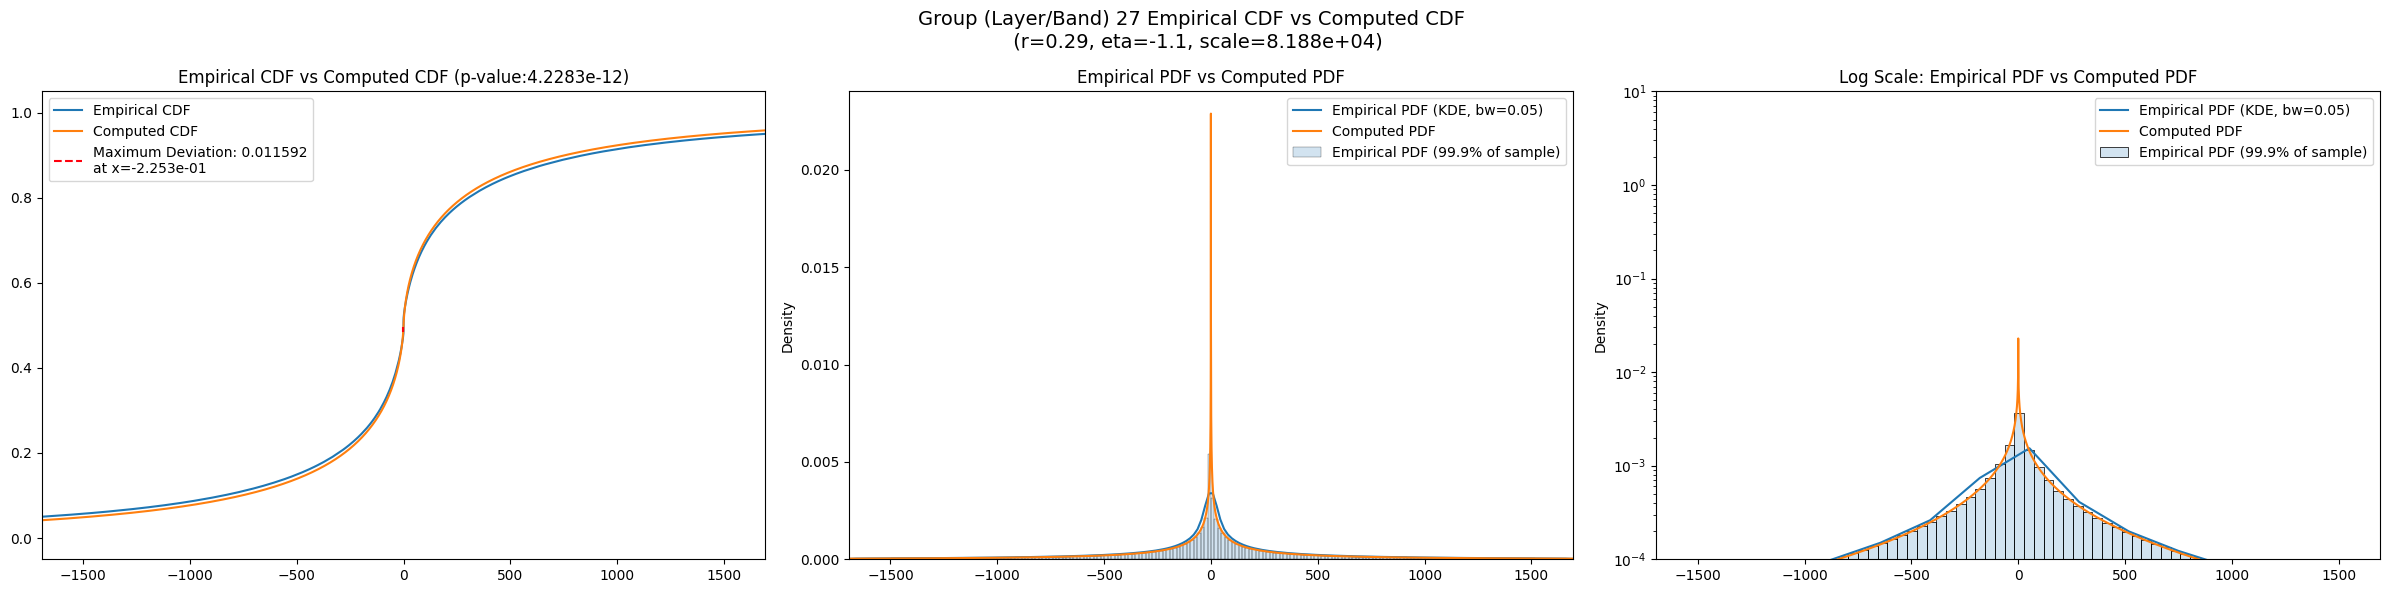

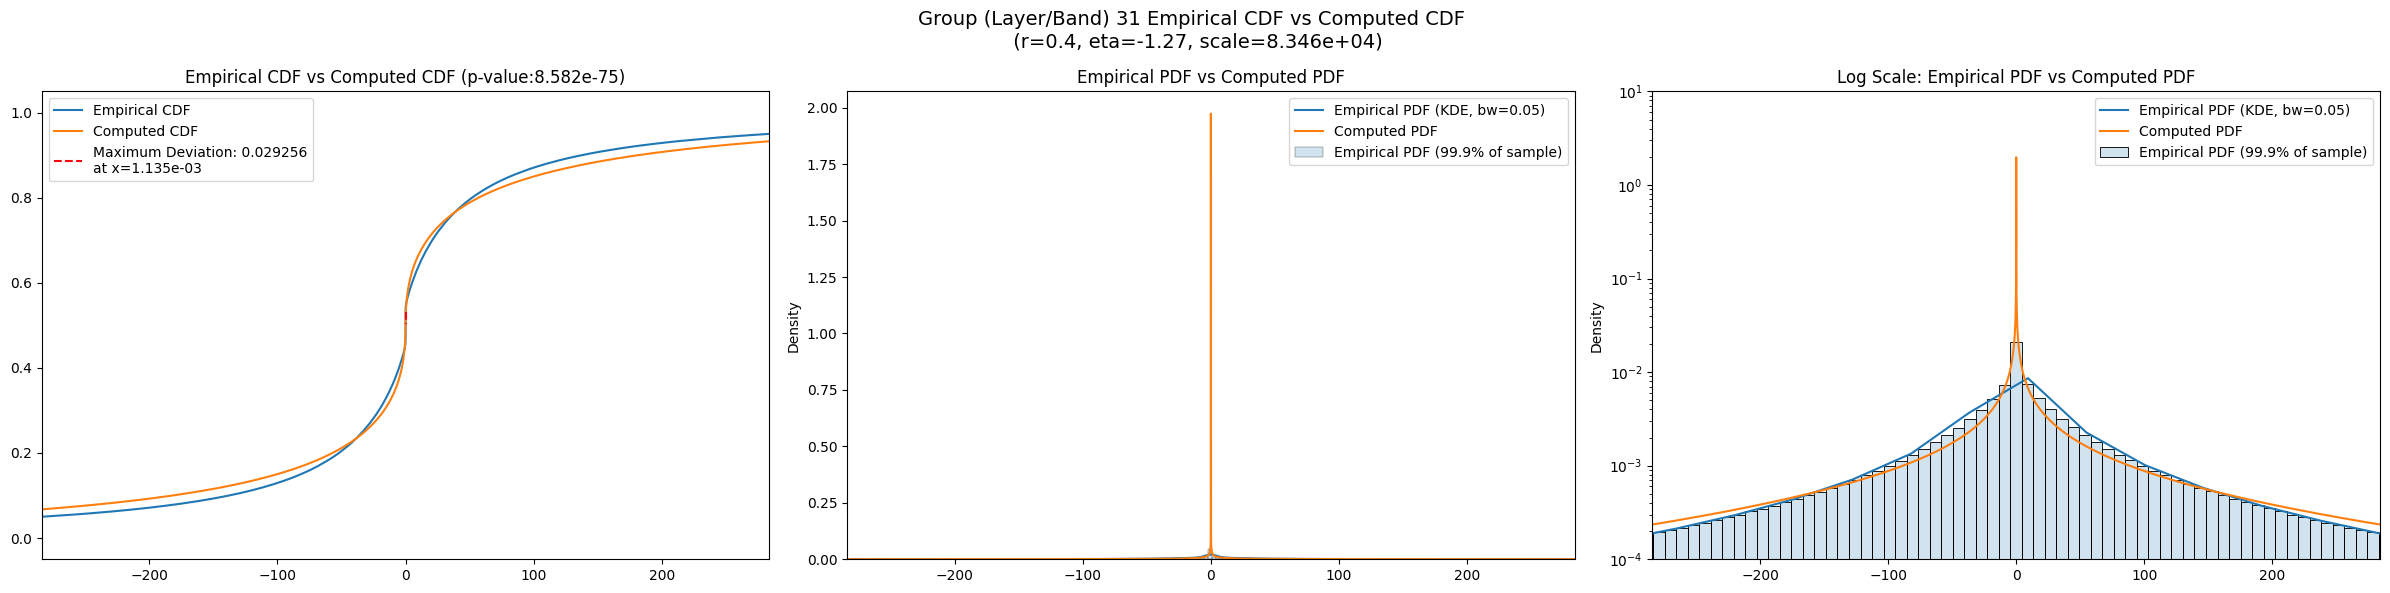

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     9.336108e+08  8.401879e+08  1.032820e+09   13.948858   11.880588   
5     2.283666e+09  2.135150e+09  2.436663e+09    4.631856    4.062694   
8     1.704543e+09  1.595908e+09  1.816450e+09    4.383642    3.860077   
11    1.321304e+09  1.240478e+09  1.403715e+09    3.787782    3.411390   
14    3.543411e+08  3.241691e+08  3.857620e+08    9.472601    8.316524   
18    6.934319e+07  6.348580e+07  7.567561e+07    9.638128    7.366555   
21    2.952826e+07  2.662045e+07  3.271980e+07   13.813057   10.137962   
24    1.138538e+07  9.675729e+06  1.334888e+07   37.156307   26.229534   
27    4.082310e+06  3.265270e+06  5.048213e+06   69.656845   46.320540   
31    1.409234e+05  1.055836e+05  1.967107e+05  147.243120   60.025883   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2      16.470263       100000.0             0.021481        0.1         -0.2   
5       5.248331       100000.0             0.034436        0.2         -0.3   
8       4.927763       100000.0             0.023430        0.2          0.2   
11      4.184121       100000.0             0.026291        0.2         -0.1   
14     10.697055       100000.0             0.020326        0.2         -0.6   
18     12.757142       100000.0             0.017004        0.2         -0.2   
21     19.820702       100000.0             0.016568        0.2         -0.5   
24     51.107258       100000.0             0.006637        0.2         -0.9   
27     98.562770       100000.0             0.012227        0.3         -1.1   
31    424.687560       100000.0             0.033937        0.3         -1.2   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       7136.6000              0.090304                   0.0   
5     ...      23643.5000              0.083653                   0.0   
8     ...      24451.9000              0.061440                   0.0   
11    ...      19598.5000              0.074485                   0.0   
14    ...       7634.3300              0.080058                   0.0   
18    ...       4269.3100              0.066420                   0.0   
21    ...       2235.3700              0.076915                   0.0   
24    ...        840.7850              0.087144                   0.0   
27    ...        383.7770              0.086547                   0.0   
31    ...         66.9312              0.080914                   0.0   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
band                                                                        
2         6478.9300             0.067831         0.000000e+00   4851.2200   
5        19932.8000             0.059761                  NaN  15789.4000   
8        20826.8000             0.036437        8.708430e-116  16759.1000   
11       16862.0000             0.048422        3.361550e-204  13315.7000   
14        6554.7200             0.054584        2.121250e-259   5123.3300   
18        3680.0500             0.040425        1.962500e-142   2893.6900   
21        1929.2000             0.051444        1.899710e-230   1498.0300   
24         729.8410             0.062313         0.000000e+00    558.9330   
27         330.3660             0.062189         0.000000e+00    252.7130   
31          56.9851             0.058107        6.165390e-294     42.9594   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.062901   0.000000e+00          1.034608e-34  
5          0.062929   0.000000e+00         2.106785e-101  
8          0.040721  1.618640e-144          5.529804e-44  
11         0.050687  1.002700e-223          3.886313e-60  
14   

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.021481                 0.004293          0.019865   
5                0.034436                 0.004293          0.034090   
8                0.023430                 0.004293          0.022391   
11               0.026291                 0.004293          0.026216   
14               0.020326                 0.004293          0.017910   
18               0.017004                 0.004293          0.014158   
21               0.016568                 0.004293          0.014151   
24               0.006637                 0.004293          0.004896   
27               0.012227                 0.004293          0.011584   
31               0.033937                 0.004293          0.030264   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.090304             0.067831       0.062901  
5                 0.083653             0.059761       0.062929  
8                 0.061440             0.036437       0.040721  
11                0.074485             0.048422       0.050687  
14                0.080058             0.054584       0.056198  
18                0.066420             0.040425       0.042504  
21                0.076915             0.051444       0.052374  
24                0.087144             0.062313       0.061904  
27                0.086547             0.062189       0.062399  
31                0.080914             0.058107       0.058601

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta     best_scale  \
band                                                                          
2           9.336108e+08          0.019865    0.15     -0.70     938.572912   
5           2.283666e+09          0.034090    0.20     -0.31   78004.131263   
8           1.679683e+09          0.022391    0.22      0.00  100000.000000   
11          1.321304e+09          0.026216    0.20     -0.09   23165.449318   
14          3.543411e+08          0.017910    0.20     -0.56   29468.906460   
18          6.934319e+07          0.014158    0.25     -0.50   82551.419048   
21          2.952826e+07          0.014151    0.24     -0.70   43839.149382   
24          1.138538e+07          0.004896    0.20     -0.92    5046.469661   
27          1.711366e+06          0.011584    0.29     -1.10   81876.725583   
31          1.155773e+05          0.030264    0.40     -1.27   83462.352440   

      best_exclude_cutoff  
band                       
2                     0.0  
5                     0.0  
8                    25.0  
11                    0.0  
14                    0.0  
18                    0.0  
21                    0.0  
24                    0.0  
27                  425.0  
31                   25.0